## Data Import

In [1]:
import os
from tqdm import tqdm

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.decomposition import FastICA
from sklearn.decomposition import TruncatedSVD

from sklearn.random_projection import SparseRandomProjection

from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# import hypertools as hyp
import seaborn as sns
from seaborn import heatmap

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
from matplotlib.pyplot import scatter

from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import gmean
from scipy.stats import hmean
from scipy.stats import moment
from scipy.stats import variation


include_test = False

# Data import
train = pd.read_csv('../data/train.csv')

if include_test:
    test = pd.read_csv('../dataVPCtest.csv')
    test_ID = test['ID']

# Target separation; ID removal
y_train = train['target']
train.drop("target", axis = 1, inplace = True)
train.drop("ID", axis = 1, inplace = True)

if include_test:
    test.drop("ID", axis = 1, inplace = True)

print("Train data shape:", train.shape)

if include_test:
    print("Train data shape:", test.shape)

Train data shape: (4459, 4991)


In [2]:
# First few values of the target variable
y_train[:5]

0    38000000.0
1      600000.0
2    10000000.0
3     2000000.0
4    14400000.0
Name: target, dtype: float64

In [3]:
# First few values of the features

train.head()

,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,dc5a8f1d8,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,0.0,0,0.0,0,0,0,0,0,2200000.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0.0,0,0.0,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0.0,0,0.0,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,0.0,0,0.0,0,0,0,0,0,2000000.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


## EDA - Exploratory Data Analysis

### Target EDA

*Statistics of the target variable*

In [4]:
y_train.describe()

count    4.459000e+03
mean     5.944923e+06
std      8.234312e+06
min      3.000000e+04
25%      6.000000e+05
50%      2.260000e+06
75%      8.000000e+06
max      4.000000e+07
Name: target, dtype: float64

*Distribution plot of the target variable*

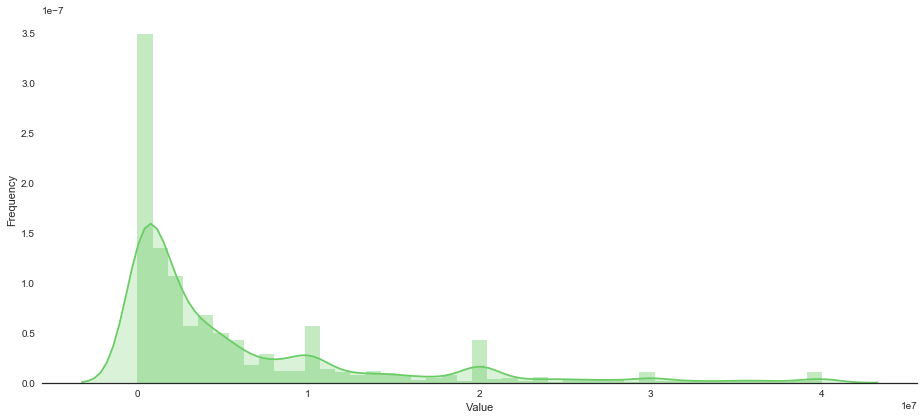

In [5]:
sns.set(style="white", palette="muted", color_codes=True)

# Set up the matplotlib figure
f, axes = plt.subplots(figsize=(13, 6), sharex=True)
sns.despine(left=True)

# Plot a simple histogram with binsize determined automatically
sns.distplot(y_train, hist=True, color="g", kde_kws={"shade": True}, ax=axes)
plt.ylabel('Frequency')
plt.xlabel('Value')

#plt.setp(axes, yticks=[])
plt.tight_layout()

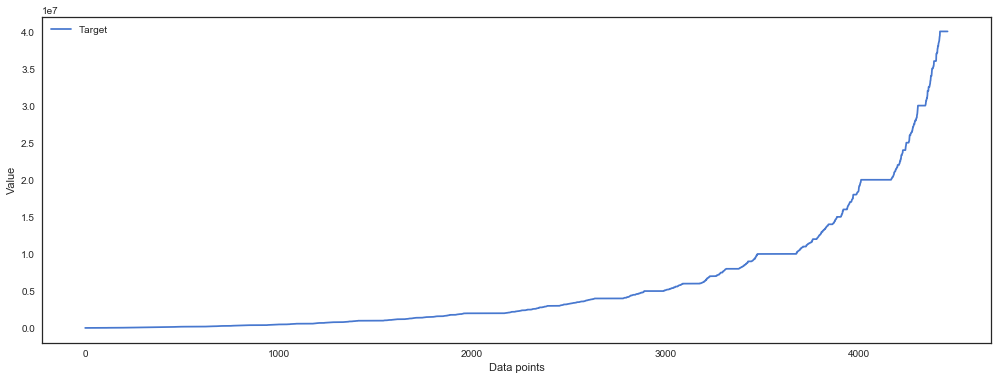

In [6]:
# Plotting Target Variable
x = np.array(y_train)
x.sort()
plt.figure(figsize=(17, 6))
plt.plot(x)
plt.title('')
plt.ylabel('Value')
plt.xlabel('Data points')
plt.legend(['Target'], loc='upper left')
plt.show()

As we can see the target variable is not normally distributed. If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most often appropriate to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a Box-Cox test, which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

We are going to use natural logarithm transformation to the target variable. This will transform it to a more suitable distribution for machine learning algorithms.

After the logarithmic transform the variable distribution will have more Gaussian shape as can be seen below.

In [7]:
np.log1p(y_train).describe()

count    4459.000000
mean       14.490239
std         1.750947
min        10.308986
25%        13.304687
50%        14.630876
75%        15.894952
max        17.504390
Name: target, dtype: float64

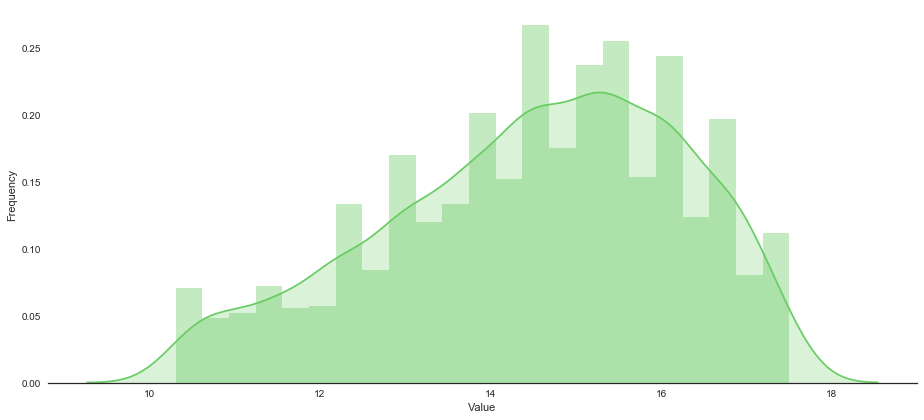

In [8]:
sns.set(style="white", palette="muted", color_codes=True)

# Set up the matplotlib figure
f, axes = plt.subplots(figsize=(13, 6), sharex=True)
sns.despine(left=True)

# Plot a simple histogram with binsize determined automatically
sns.distplot(np.log1p(y_train), hist=True, color="g", kde_kws={"shade": True}, ax=axes)
plt.ylabel('Frequency')
plt.xlabel('Value')

#plt.setp(axes, yticks=[])
plt.tight_layout()

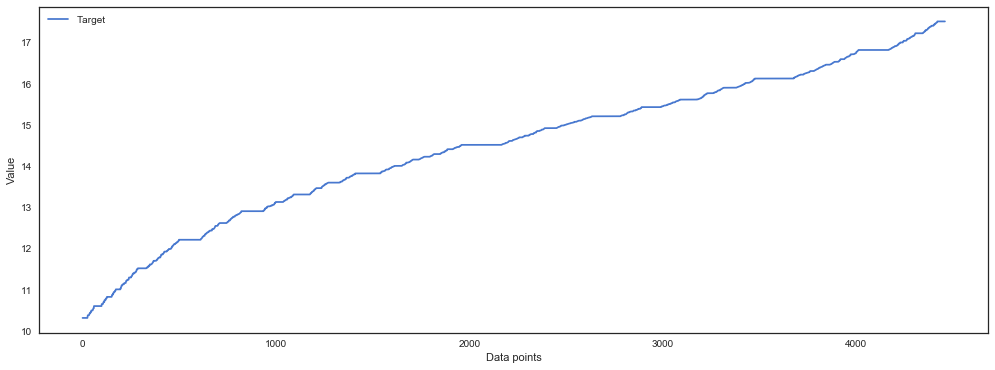

In [9]:
x = np.array(np.log1p(y_train))
x.sort()
plt.figure(figsize=(17, 6))
plt.plot(x)
plt.title('')
plt.ylabel('Value')
plt.xlabel('Data points')
plt.legend(['Target'], loc='upper left')
plt.show()

### Feature EDA

Plot of the first feature across all data points can be seen below.

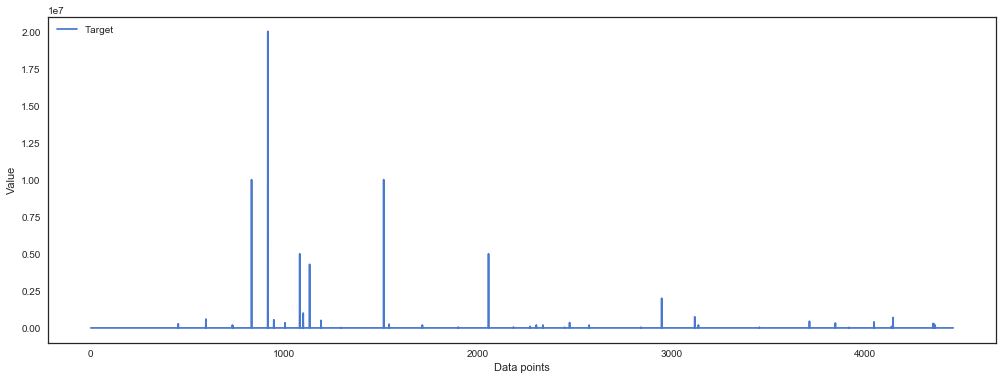

In [10]:
x = np.array(train[train.columns[0]])
plt.figure(figsize=(17, 6))
plt.plot(x)
plt.title('')
plt.ylabel('Value')
plt.xlabel('Data points')
plt.legend(['Target'], loc='upper left')
plt.show()

As we can the data is pretty sparse.

We are going to plot a few more features.

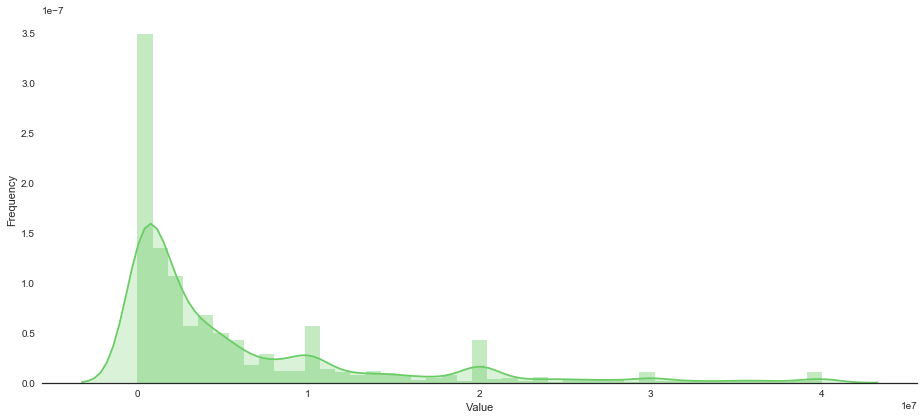

In [11]:
sns.set(style="white", palette="muted", color_codes=True)

# Set up the matplotlib figure
f, axes = plt.subplots(figsize=(13, 6), sharex=True)
sns.despine(left=True)

# Plot a simple histogram with binsize determined automatically
sns.distplot(y_train, hist=True, color="g", kde_kws={"shade": True}, ax=axes)
plt.ylabel('Frequency')
plt.xlabel('Value')
#plt.setp(axes, yticks=[])
plt.tight_layout()

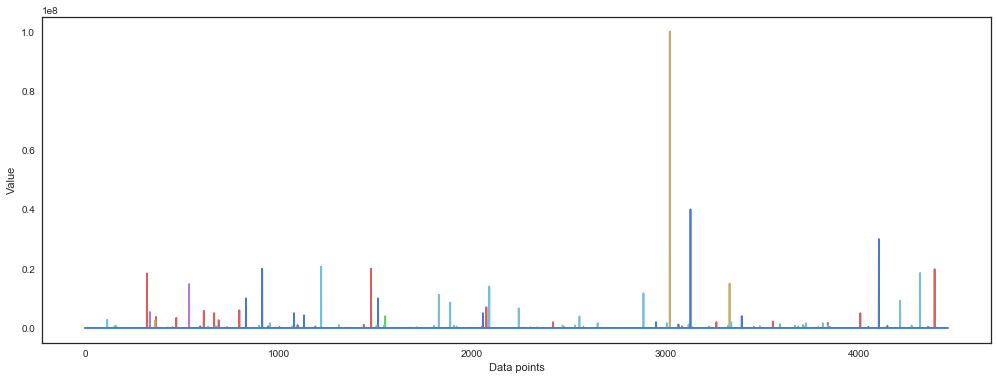

In [12]:
x = np.array(train[train.columns[:7]])
plt.figure(figsize=(17, 6))
plt.plot(x)
plt.title('')
plt.ylabel('Value')
plt.xlabel('Data points')
plt.show()

We can see that the data is sparse in all of the selected feature and that there is large data variation within the features.

If we apply the log transform to the selected feature we get a better feature value distribution as can be seen below:


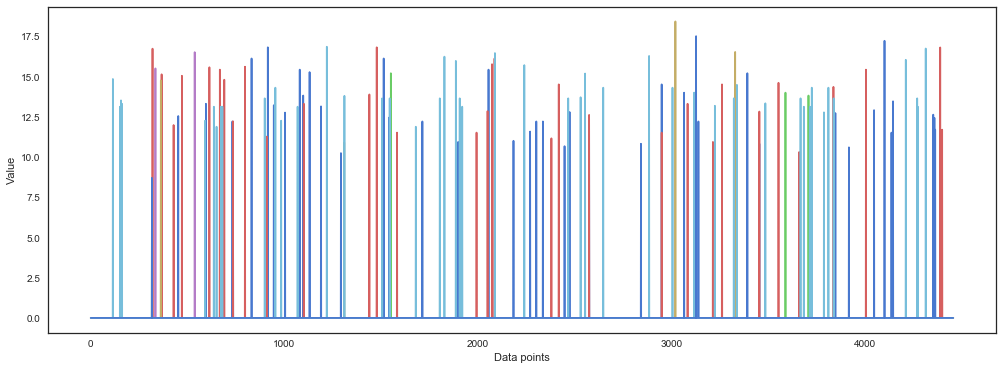

In [13]:
x = np.log1p(np.array(train[train.columns[:7]]))
plt.figure(figsize=(17, 6))
plt.plot(x)
plt.title('')
plt.ylabel('Value')
plt.xlabel('Data points')
plt.show()

The analysis performed so far indicates that we are working with sparse data. Sparcity and density coefficients have been calculated below.

In [14]:
def check_sparsity(df):
    non_zeros = (df.ne(0).sum(axis=1)).sum()
    total = train.shape[1]*train.shape[0]
    zeros = total - non_zeros
    sparsity = round(zeros / total * 100,2)
    density = round(non_zeros / total * 100,2)

    print(" Total:",total,"\n Zeros:", zeros, "\n Sparsity [%]: ", sparsity, "\n Density [%]: ", density)
    return density

d1 = check_sparsity(train)

 Total: 22254869 
 Zeros: 21554760 
 Sparsity [%]:  96.85 
 Density [%]:  3.15


Vast majority of the data are zeros while non-zero values represent only about 3.15%. We can calculate and plot the distribution of zero elements both column-wise and row-wise to get some additional information about the data.

In [15]:
non_zeros_1 = (train.ne(0).sum(axis=1)) # number of zero elements columnwise
non_zeros_0 = (train.ne(0).sum(axis=0)) # number of zero elements rowwies

Distribution of zeros column-wise

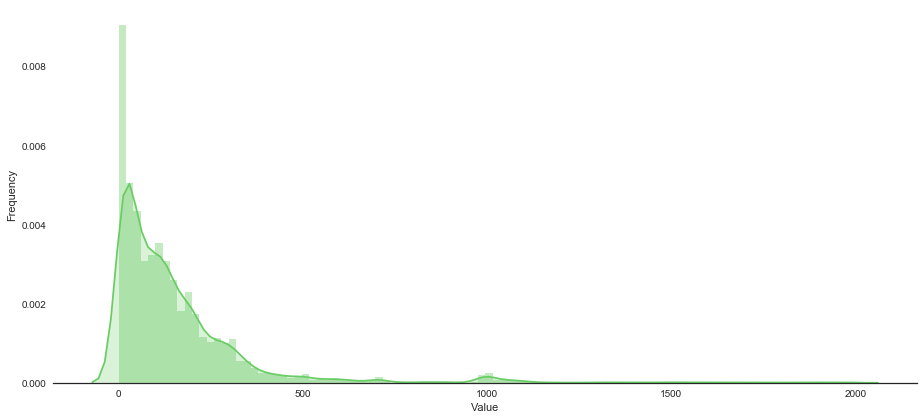

In [16]:
sns.set(style="white", palette="muted", color_codes=True)

# Set up the matplotlib figure
f, axes = plt.subplots(figsize=(13, 6), sharex=True)
sns.despine(left=True)

# Plot a simple histogram with binsize determined automatically
sns.distplot(non_zeros_1, hist=True, color="g", kde_kws={"shade": True}, ax=axes, bins = 100)
plt.ylabel('Frequency')
plt.xlabel('Value')
#plt.setp(axes, yticks=[])
plt.tight_layout()

Distribution of zeros row-wise

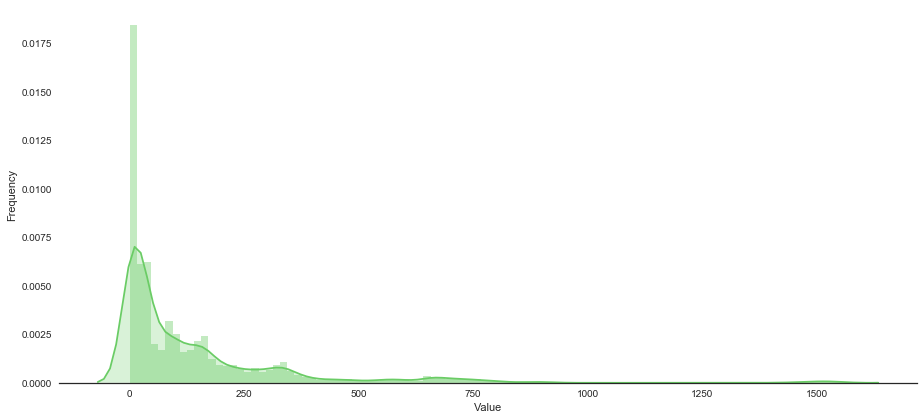

In [17]:
sns.set(style="white", palette="muted", color_codes=True)

# Set up the matplotlib figure
f, axes = plt.subplots(figsize=(13, 6), sharex=True)
sns.despine(left=True)
plt.ylabel('Frequency')
plt.xlabel('Value')
# Plot a simple histogram with binsize determined automatically
sns.distplot(non_zeros_0, hist=True, color="g", kde_kws={"shade": True}, ax=axes, bins = 100)


plt.tight_layout()

Data can be plotted using a heat map to further visualize sparse distribution of the features.

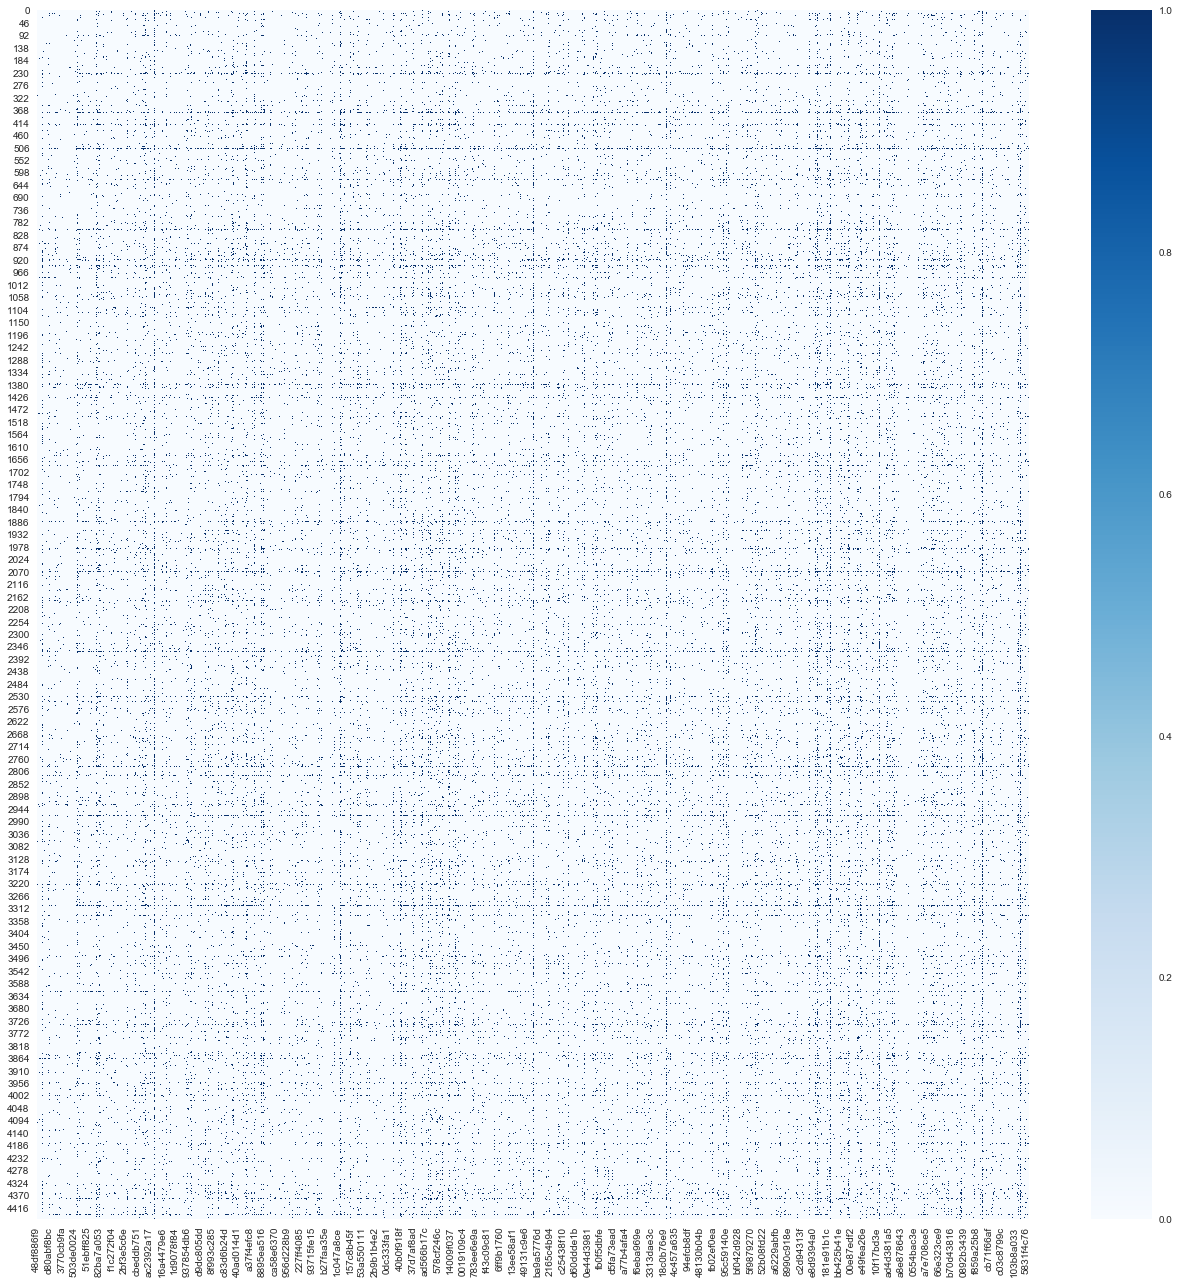

In [18]:
# Set up the matplotlib figure
f, axes = plt.subplots(figsize=(18, 18), sharex=True)

# Plot a simple histogram with binsize determined automatically
heatmap(train, vmin=0, vmax=1, cmap="Blues")

plt.tight_layout()

We can also apply some dimensionality reduction technique like PCA - Principal component analysis and then plot the data in two or more dimensions.

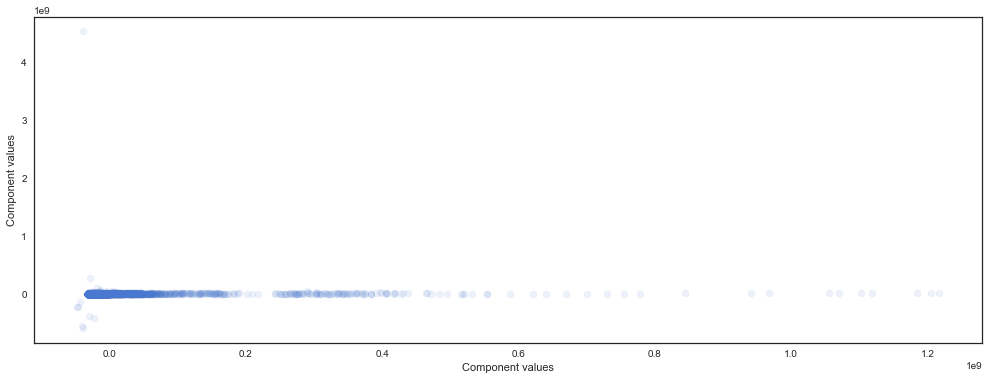

In [19]:
pca = PCA(n_components=40, copy=True, whiten=False)
train_pca = pca.fit_transform(train)
plt.figure(figsize=(17, 6))
plt.ylabel('Component values')
plt.xlabel('Component values')



scatter(train_pca[:,0], train_pca[:,1], alpha = 0.1)

We see that due to high data skewness the data was not separated well in two dimensions. We can try applying the natural logarithm transform of the data first and then dimensionality reduction and separation.

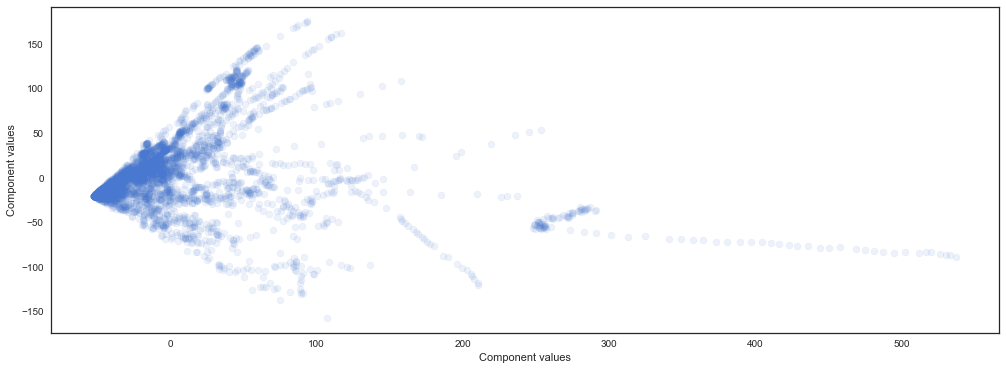

In [20]:
pca = PCA(n_components=40, copy=True, whiten=False)
train_pca = pca.fit_transform(np.log1p(train))
plt.figure(figsize=(17, 6))
plt.ylabel('Component values')
plt.xlabel('Component values')
scatter(train_pca[:,0], train_pca[:,1], alpha = 0.1)

The above plot seems to show more structure of the data then the one without the logarithm transform. We can show it in three dimension using hypertools and first three PCA components.

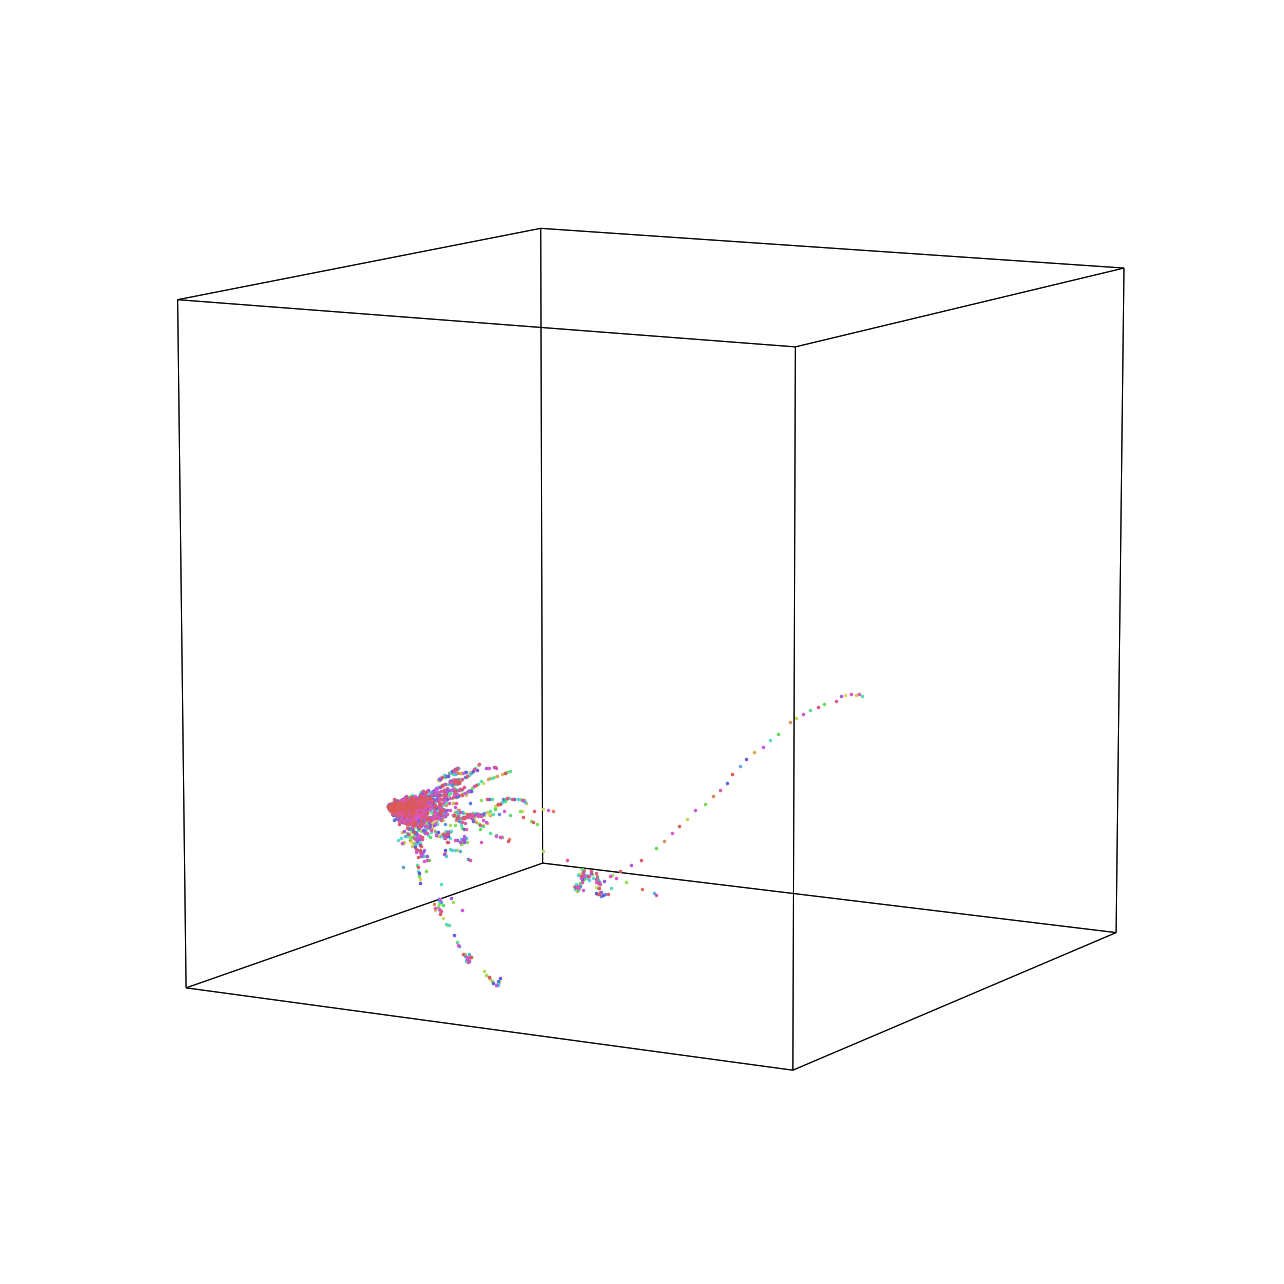

In [21]:
hyp.plot(np.log1p(train), n_clusters = 4000, size=[18,18], reduce = "PCA", ndims = 3, normalize = "across")

PCA dimensionality reduction of the training data can also be visualized using a heatmap. This has been done using first 40 PCA components.

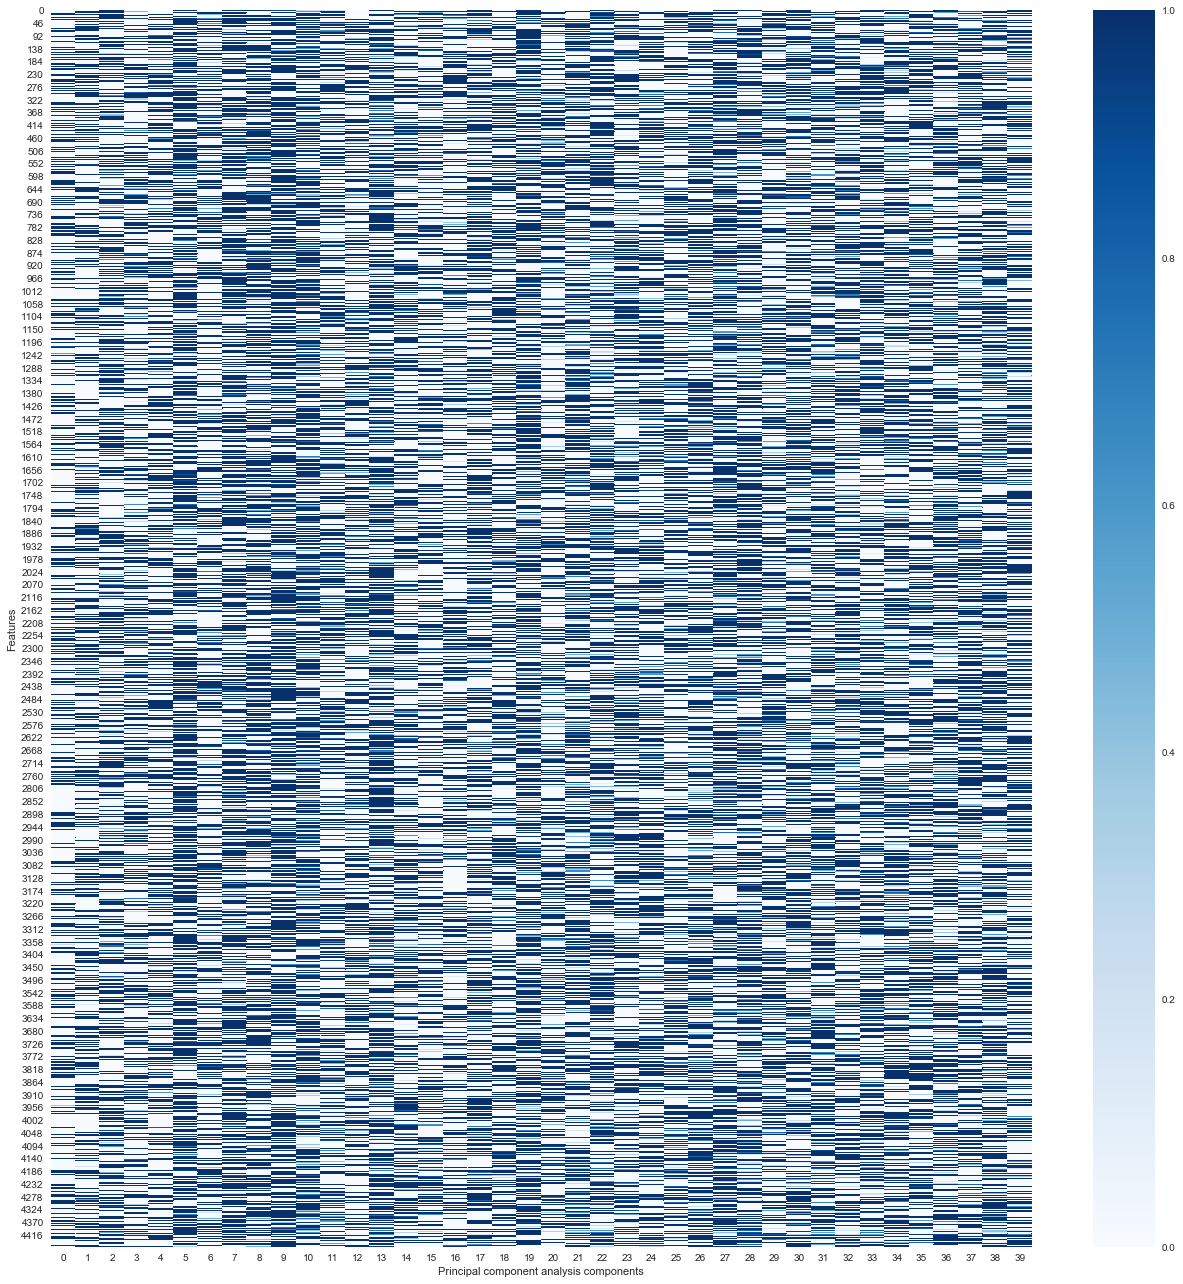

In [22]:
# Set up the matplotlib figure
f, axes = plt.subplots(figsize=(18, 18), sharex=True)

# Plot a simple histogram with binsize determined automatically
heatmap(train_pca, vmin=0, vmax=1, cmap="Blues")
plt.ylabel('Features')
plt.xlabel('Principal component analysis components')
plt.tight_layout()

The above examples of PCA generate a relatively dense matrix from the data. Given that we have sparse data source we can also use Sparse Random Projection algorithms to output a sparse matrix. 

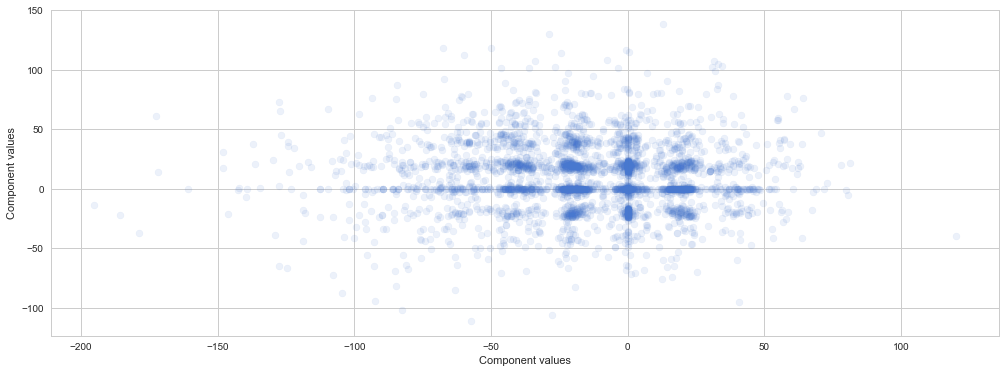

In [23]:
srp = SparseRandomProjection(n_components=40, eps=0.5)

train_srp = srp.fit_transform(np.log1p(train))
plt.figure(figsize=(17, 6))

plt.ylabel('Component values')
plt.xlabel('Component values')
scatter(train_srp[:,0], train_srp[:,1], alpha = 0.1, color = "b")

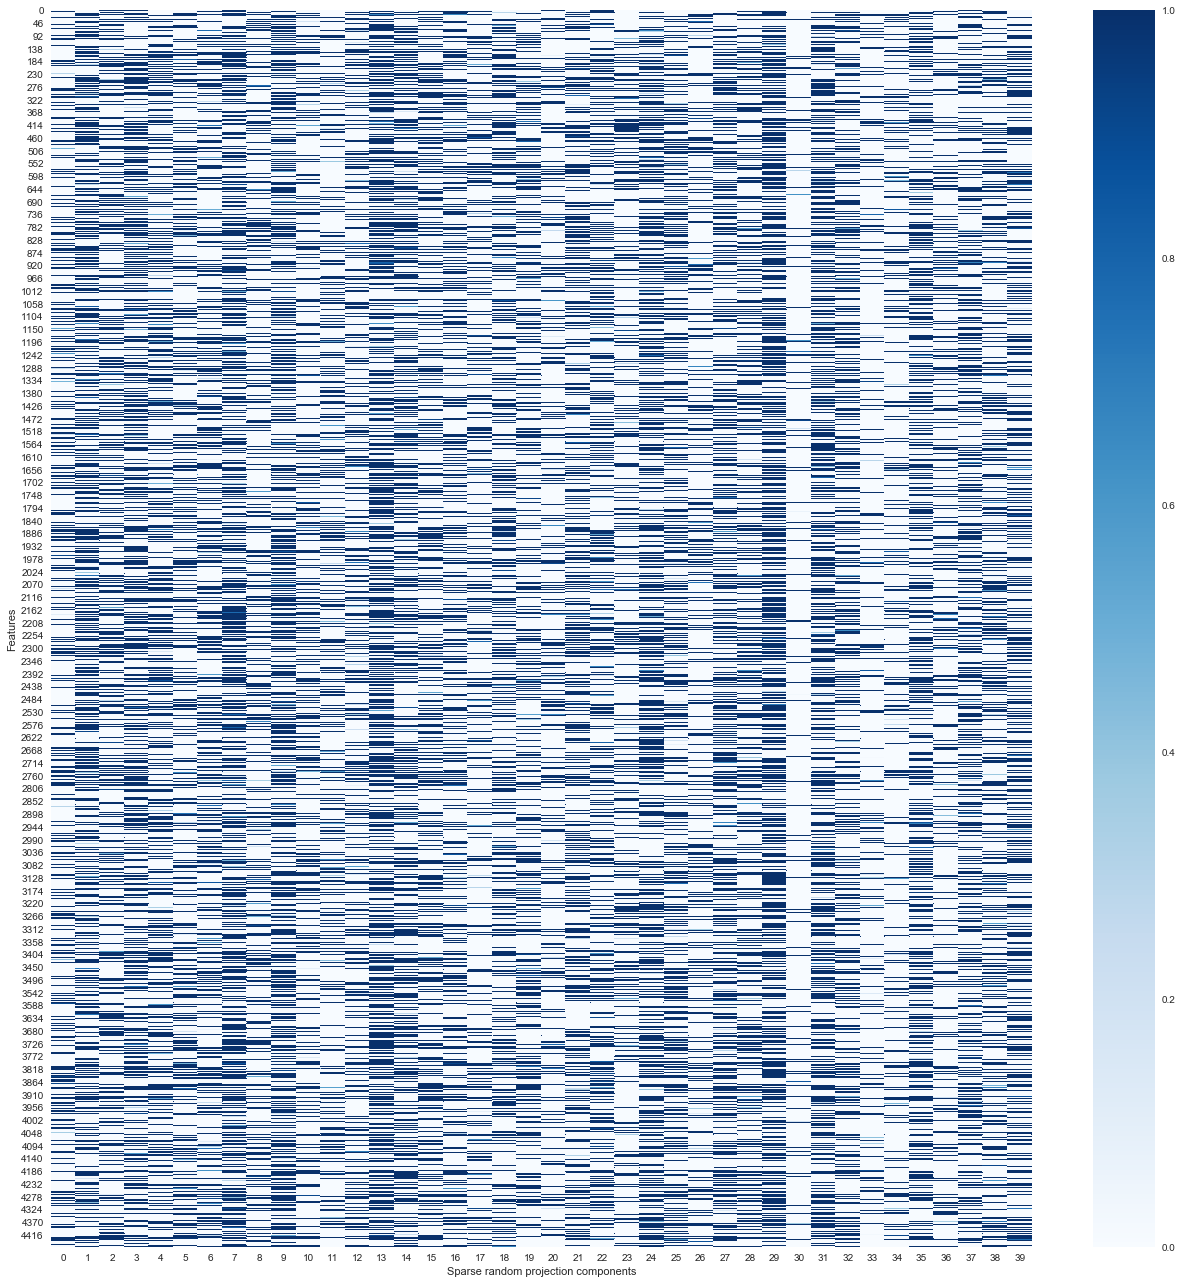

In [24]:
# Set up the matplotlib figure
f, axes = plt.subplots(figsize=(18, 18), sharex=True)

# Plot a simple histogram with binsize determined automatically
heatmap(train_srp, vmin=0, vmax=1, cmap="Blues")
plt.ylabel('Features')
plt.xlabel('Sparse random projection components')
plt.tight_layout()

The Sparse Random Projection algorithm produced a much sparser matrix than PCA. In the feature engineering section we will use both to expand our dataset.

### Correlation between features and target variable

### Mutual information regression

Correlation between features and target variable can be estimate using mutual_info_regression function from SciKit Learn library. Mutual_info_regression is suitable metric for sparse data. Mutual information between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.

In [25]:
corr = mutual_info_regression(np.log1p(train), np.log1p(y_train))

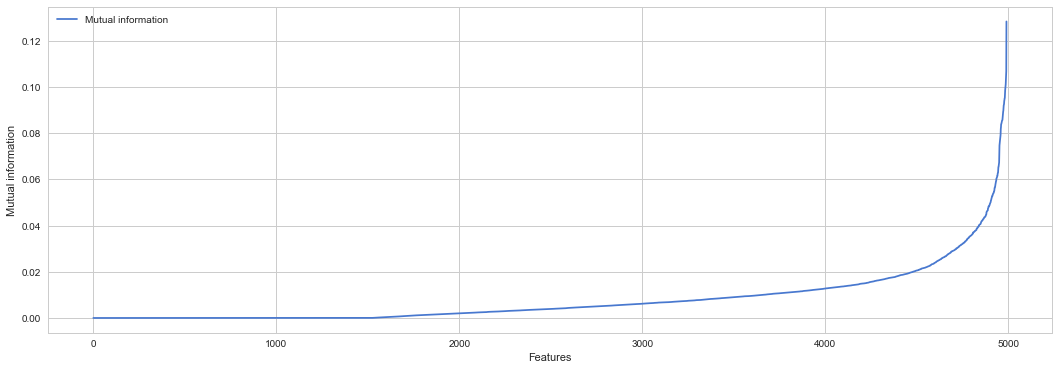

In [26]:
x = np.array(corr)
x.sort()
plt.figure(figsize=(18, 6))
plt.plot(x, color = "b")
plt.title('')
plt.ylabel('Mutual information')
plt.xlabel('Features')
plt.legend(['Mutual information'], loc='upper left')
plt.show()

It seems that there are many variables with no correlation with target variable. But there are quite a few that correlate relatively well. We will make a list of all the features and their correlation with the target variable which will be used in feature engineering.

In [27]:
mi_selection = pd.DataFrame({'importance': corr, 'feature': train.columns}).sort_values(
              by=['importance'], ascending=[False])

### Univariate linear regression test

We are also going to use univariate linear regression test to investigate the similarity between features and target variable.

In [28]:
corr = f_regression(np.log1p(train), np.log1p(y_train))

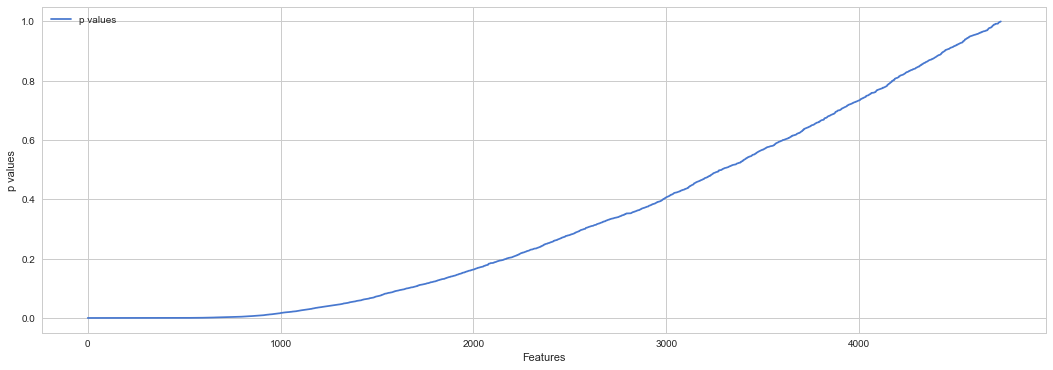

In [29]:
x = np.array(corr[1])
x.sort()
plt.figure(figsize=(18, 6))
plt.plot(x, color = "b")
plt.title('')
plt.ylabel('p values')
plt.xlabel('Features')
plt.legend(['p values'], loc='upper left')
plt.show()

This test also reveals that there are many variables with 0 correlation with target variable. But ther are quite a few that correlate relatively well. We will make a list of all these features and their correlation with the target value which will be used in feature engineering.

In [30]:
f_selection = pd.DataFrame({'importance': corr[1], 'feature': train.columns}).sort_values(
              by=['importance'], ascending=[False])
col = f_selection[:10]['feature'].values

### Correlation between features

Very high correlation between features is not a desirable property of training data for machine learning algorithms. Highly correlated features case the algorithm to relay too heavily on them compered to the other features and thus can result in higher error. It is necessary to remove these features from the dataset if there are any. One way to test this is by using the pandas correlation function that calculates the correlation between all individual features.

In [31]:
data_corr = np.log1p(train).corr()

The results can be visualized using a heatmap.

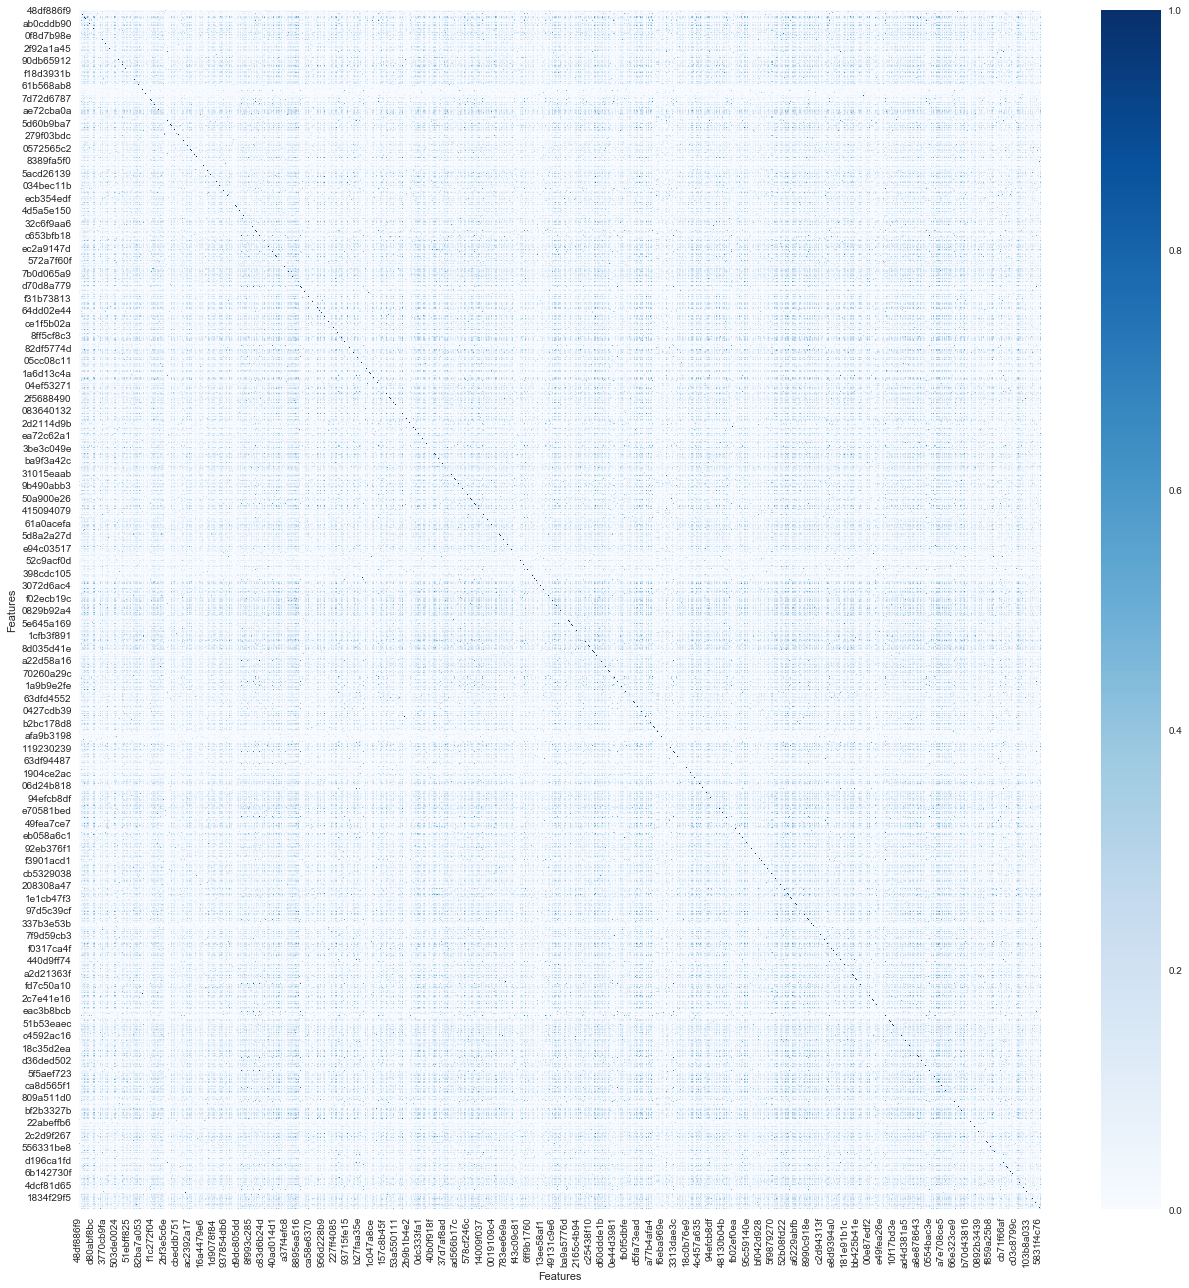

In [32]:
# Set up the matplotlib figure
f, axes = plt.subplots(figsize=(18, 18), sharex=True)

# Plot a simple histogram with binsize determined automatically
heatmap(data_corr, vmin=0, vmax=1, cmap="Blues")
plt.ylabel('Features')
plt.xlabel('Features')
plt.tight_layout()

We can extract the number of the features with high correlation.

In [33]:
colnew = []

for i in data_corr.columns:
    if len(data_corr[(data_corr[i]>0.99) & (data_corr[i]!=1)]) >= 1:
        colnew.append(i)
len(colnew)

78

Considering that we are going to use several data dimensionally reduction techniques in the feature engineering section we will not remove any of the high correlated features identified here.

## Data Preprocessing

In [34]:
train = np.log1p(train)
y_train = np.log1p(y_train)

if include_test:
    test = np.log1p(test)

cols_with_onlyone_val = train.columns[train.nunique() == 1]
print("Removing {} columns with no variance.".format(len(cols_with_onlyone_val)))
train.drop(cols_with_onlyone_val.values, axis=1, inplace=True)

if include_test:
    test.drop(cols_with_onlyone_val.values, axis=1, inplace=True)

def RemoveDuplicateColumns():
    colsToRemove = []
    columns = train.columns
    for i in range(len(columns)-1):
        v = train[columns[i]].values
        dupCols = []
        for j in range(i + 1,len(columns)):
            if np.array_equal(v, train[columns[j]].values):
                colsToRemove.append(columns[j])
    train.drop(colsToRemove, axis=1, inplace=True) 
    test.drop(colsToRemove, axis=1, inplace=True)

#RemoveDuplicateColumns()

print("Train data shape:", train.shape)

if include_test:
    print("Train data shape:", test.shape)

Removing 256 columns with no variance.
Train data shape: (4459, 4735)


## Testing Algorithms

Before we test some algorithms on the data we will create a baseline using a naive predictor. We will calculate the error using a RMSE - Root Mean Square Error metric using target mean as our prediction for all data points.

In [35]:
# Naive predictior using mean target

np.sqrt(np.mean((y_train - np.mean(y_train))**2))

1.7507504829494556

In [36]:
# Splitting the data into test and train data

from sklearn.model_selection import train_test_split

X1, X2, y1, y2 = train_test_split(train, y_train.values, test_size=0.20, random_state=100)

In [37]:
# Creating a scoring function

def scoring_fun(y, predy):
    return np.sqrt(mean_squared_error(y, predy))

my_scorer = make_scorer(scoring_fun)

Following algorithms will be tested:

    •Linear Regression
    •Lasso
    •Ridge
    •ElasticNet
    •MLPRegressor 
    •LightGBM

Linear Regression

In [38]:
model = LinearRegression(fit_intercept=False, normalize=False, copy_X=True, n_jobs=1)

scores = cross_val_score(model, train[col], y_train.values, cv=5, scoring=my_scorer)
print("Cross-Validation Error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

model.fit(X1[col],y1)
print("Train Error: %0.2f" % (scoring_fun(y1,model.predict(X1[col]))))
print("Test Error: %0.2f" % (scoring_fun(y2,model.predict(X2[col]))))

Cross-Validation Error: 13.30 (+/- 0.24)
Train Error: 13.27
Test Error: 13.39


Lasso - Linear regression with L1 regularizer

In [39]:
alpha = 0.0007
model = Lasso(alpha=alpha, normalize=True, max_iter=10000, tol=0.0001, selection ="random")

scores = cross_val_score(model, train, y_train.values, cv=5, scoring=my_scorer)
print("Cross-Validation Error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

model.fit(X1,y1)
print("Train Error: %0.2f" % (scoring_fun(y1,model.predict(X1))))
print("Test Error: %0.2f" % (scoring_fun(y2,model.predict(X2))))

Cross-Validation Error: 1.68 (+/- 0.10)
Train Error: 1.55
Test Error: 1.64


Ridge - Linear regression with L2 regularizer

In [40]:
model = Ridge(alpha=250000, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001)

scores = cross_val_score(model, train, y_train.values, cv=5, scoring=my_scorer)
print("Cross-Validation Error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

model.fit(X1,y1)
print("Train Error: %0.2f" % (scoring_fun(y1,model.predict(X1))))
print("Test Error: %0.2f" % (scoring_fun(y2,model.predict(X2))))


Cross-Validation Error: 1.67 (+/- 0.09)
Train Error: 1.59
Test Error: 1.61


In [41]:
model = Ridge(alpha=250000, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001)

scores = cross_val_score(model, train, y_train.values, cv=5, scoring=my_scorer)
print("Cross-Validation Error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

model.fit(X1,y1)
print("Train Error: %0.2f" % (scoring_fun(y1,model.predict(X1))))
print("Test Error: %0.2f" % (scoring_fun(y2,model.predict(X2))))

Cross-Validation Error: 1.67 (+/- 0.09)
Train Error: 1.59
Test Error: 1.61


ElasticNet - Linear regression with L1 and L2 as regularizers

In [42]:
model = ElasticNet(alpha=0.2, copy_X=True, fit_intercept=True, l1_ratio=0.6,
      max_iter=10000, normalize=False, positive=False, precompute=False,
      random_state=None, selection= "cyclic", tol=0.0001, warm_start=False)

scores = cross_val_score(model, train, y_train.values, cv=5, scoring=my_scorer)
print("Cross-Validation Error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

model.fit(X1,y1)
print("Train Error: %0.2f" % (scoring_fun(y1,model.predict(X1))))
print("Test Error: %0.2f" % (scoring_fun(y2,model.predict(X2))))

Cross-Validation Error: 1.69 (+/- 0.09)
Train Error: 1.60
Test Error: 1.63


KNeighborsRegressor - Regression based on k-nearest neighbors

In [43]:
model = KNeighborsRegressor(n_neighbors=20, weights = 'distance')

scores = cross_val_score(model, train, y_train.values, cv=5, scoring=my_scorer)
print("Cross-Validation Error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

model.fit(X1,y1)
print("Train Error: %0.2f" % (scoring_fun(y1,model.predict(X1))))
print("Test Error: %0.2f" % (scoring_fun(y2,model.predict(X2))))

Cross-Validation Error: 1.79 (+/- 0.06)
Train Error: 0.00
Test Error: 1.75


Multi-layer Perceptron regressor

In [44]:
model = MLPRegressor(hidden_layer_sizes=(40,10,10), alpha = 100) 

scores = cross_val_score(model, train, y_train.values, cv=5, scoring=my_scorer)
print("Cross-Validation Error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

model.fit(X1,y1)
print("Train Error: %0.2f" % (scoring_fun(y1,model.predict(X1))))
print("Test Error: %0.2f" % (scoring_fun(y2,model.predict(X2))))

Cross-Validation Error: 2.62 (+/- 0.53)
Train Error: 1.04
Test Error: 2.42


LightGBM  - Gradient boosting decision tree algorithm

In [45]:
model = LGBMRegressor(objective='regression', metric='rmse') 

scores = cross_val_score(model, train, y_train.values, cv=5, scoring=my_scorer)
print("Cross-Validation Error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

model.fit(X1,y1)
print("Train Error: %0.2f" % (scoring_fun(y1,model.predict(X1))))
print("Test Error: %0.2f" % (scoring_fun(y2,model.predict(X2))))

Cross-Validation Error: 1.46 (+/- 0.11)
Train Error: 0.83
Test Error: 1.48


For all the algorithms tested above a simple tuning of hyperparameters was performed to get a sense of the algorithms ability to model the data. Linear regression algorithm cannot model the data well. The error is worse even compared to the naïve predictor using mean as a prediction for all data points. Lasso, Ridge and ElasticNet are all algorithms based on linear regression with regularization. Lasso with L1 regularization, Ridge with L2 regularization and ElasticNet with L1 and L2 regularization. These algorithms preform considerably better than the ordinary linear regression. The Lasso algorithm has a cross-validation error of 1.68 same as Ridge repressor. The EasticNet algorithm error is similar at 1.69. KNeighborsRegressor performed pretty badly as well having the test error equal to the naive predictor. The MLPRegressor has even worse cross-validation error then the naïve predictor. This is probably due to inadequate tuning. The LightGBM algorithm has the lowers cross validation error of 1.46. The analysis preformed above shows that the most promising algorithm for this task is LGBMRegressor.

# Feature engineering

### PCA Analysis

One option for dimensionality reduction is PCA. PCA is linear dimensionality reduction technique using singular value decomposition of the data to project it to a lower dimensional space. We will create a PCA dataset with 1000 components.

In [46]:
pca = PCA(n_components=1000)
train_PCA = pca.fit_transform(train)
pca.explained_variance_ratio_.sum()

0.9149265571133416

First 1000 components explain 91.5% of the variance in the data. We can plot individual components of PCA and show how much variance each component explains individually. See figure below.

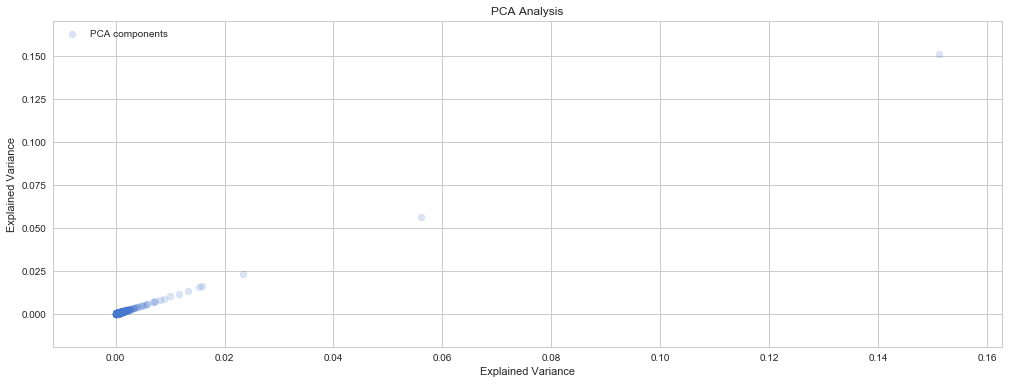

In [47]:
plt.figure(figsize=(17, 6))
plt.scatter(pca.explained_variance_ratio_, pca.explained_variance_ratio_, alpha = 0.2, color = "b")

plt.title('PCA Analysis')
plt.ylabel('Explained Variance')
plt.xlabel('Explained Variance')
plt.legend(['PCA components'], loc='upper left')
plt.show()


Next we will train our LightGBM model on the first 50 PCA components. We will start be training it on only one component then two comments and so on till first 50 components have been tested.

In [48]:
reg = LGBMRegressor(objective='regression', metric='rmse')

score = [[],[],[],[]]

for i in range(1,51,1):
    
    X1, X2, y1, y2 = train_test_split(train_PCA[:,:i], y_train.values, test_size=0.20, random_state=0)
    
    scores = cross_val_score(reg, train_PCA[:,:i], y_train.values, cv=5, scoring=my_scorer)
    
    reg.fit(X1,y1)
    score[0].append(i)
    score[1].append(scores.mean())
    score[2].append(scoring_fun(y1,reg.predict(X1)))
    score[3].append(scoring_fun(y2,reg.predict(X2)))
    

We can plot the cross-validation score, training score and testing score in relation to number of PCA components selected to determine how many components we should select.

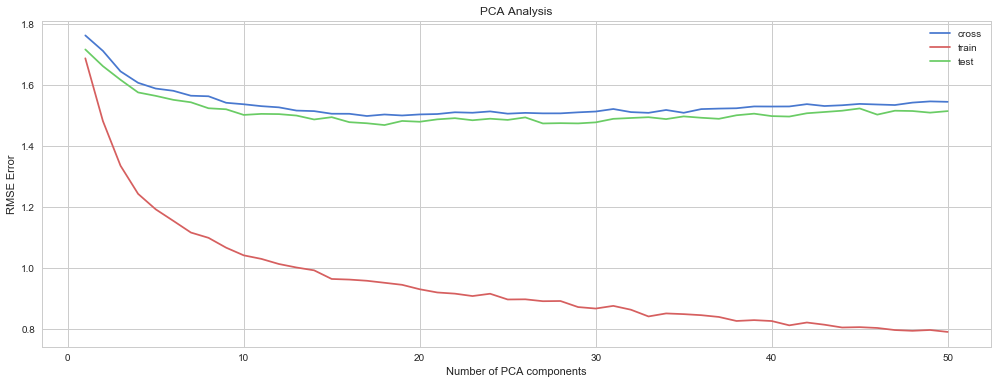

In [49]:
plt.figure(figsize=(17, 6))
plt.plot(score[0], score[1], color = "b")
plt.plot(score[0], score[2], color = "r")
plt.plot(score[0], score[3], color = "g")
plt.title('PCA Analysis')
plt.ylabel('RMSE Error')
plt.xlabel('Number of PCA components')
plt.legend(['cross','train','test'], loc='upper right')
plt.show()

It seems that first 20 components results in the smallest error with minimal overfitting of the data. So we will save our 20 PCA components which we will use to expand our dataset.

### Sparse Random Projection

Dimensionality reduction can also be achieved through sparse random projection. Sparse random matrix is an alternative to dense random projection matrix that guarantees similar embedding quality while being much more memory efficient and allowing faster computation of the projected data.

In [50]:
srp = SparseRandomProjection(n_components='auto', eps=0.28, dense_output=False)
train_SRP = srp.fit_transform(train)
train_SRP.shape

(4459, 1054)

In [51]:
reg = LGBMRegressor(objective='regression', metric='rmse')

score = [[],[],[],[]]

for i in range(1,101,1):
    
    X1, X2, y1, y2 = train_test_split(train_SRP[:,:i], y_train.values, test_size=0.20, random_state=0)
    
    scores = cross_val_score(reg, train_SRP[:,:i], y_train.values, cv=5, scoring=my_scorer)
    
    reg.fit(X1,y1)
    score[0].append(i)
    score[1].append(scores.mean())
    score[2].append(scoring_fun(y1,reg.predict(X1)))
    score[3].append(scoring_fun(y2,reg.predict(X2)))

Next we will train our LightGBM model on the first 100 Sparse Random Projection components. We will start be training it on only one component then two components and so on till first 100 components have been tested.

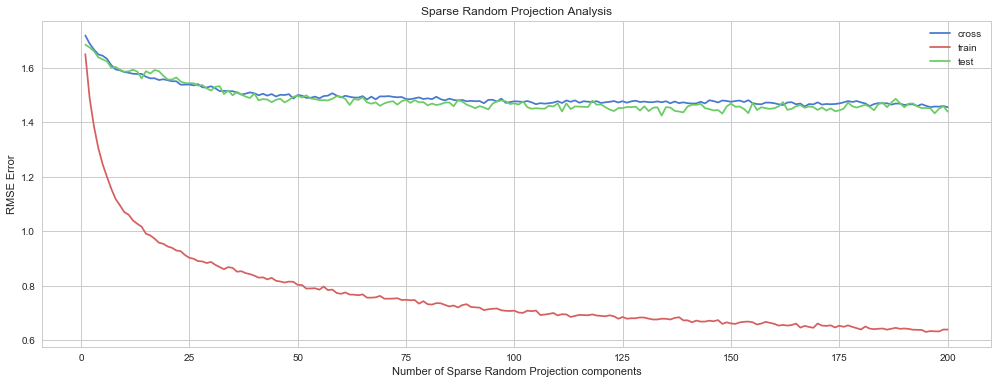

In [52]:
plt.figure(figsize=(17, 6))
plt.plot(score[0], score[1], color = "b")
plt.plot(score[0], score[2], color = "r")
plt.plot(score[0], score[3], color = "g")
plt.title('Sparse Random Projection Analysis')
plt.ylabel('RMSE Error')
plt.xlabel('Number of Sparse Random Projection components')
plt.legend(['cross','train','test'], loc='upper right')
plt.show()

It seems that first 75 components results in the smallest error with minimal overfitting of the data. So we will save our 75 PCA components which we will use to expand our dataset.

### TruncatedSVD

This dimensionality reduction transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with scipy.sparse matrices efficiently.

In [53]:
tsvd = TruncatedSVD(n_components=1000, algorithm="randomized", n_iter=5, random_state=None, tol=0.0)
train_TSVD = tsvd.fit_transform(train)
tsvd.explained_variance_ratio_.sum()

0.915434410610925

In [54]:
reg = LGBMRegressor(objective='regression', metric='rmse')

score = [[],[],[],[]]

for i in range(1,51,1):
    
    X1, X2, y1, y2 = train_test_split(train_TSVD[:,:i], y_train.values, test_size=0.20, random_state=0)
    
    scores = cross_val_score(reg, train_TSVD[:,:i], y_train.values, cv=5, scoring=my_scorer)
    
    reg.fit(X1,y1)
    score[0].append(i)
    score[1].append(scores.mean())
    score[2].append(scoring_fun(y1,reg.predict(X1)))
    score[3].append(scoring_fun(y2,reg.predict(X2)))

Next we will train our LightGBM model on the first 50 TruncatedSVD components. We will start be training it on only one component then two components and so on till first 50 components have been tested.

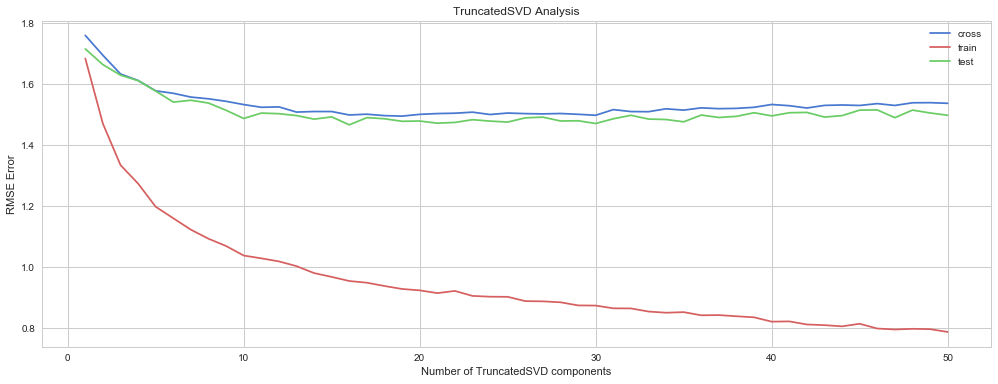

In [55]:
plt.figure(figsize=(17, 6))
plt.plot(score[0], score[1], color = "b")
plt.plot(score[0], score[2], color = "r")
plt.plot(score[0], score[3], color = "g")
plt.title('TruncatedSVD Analysis')
plt.ylabel('RMSE Error')
plt.xlabel('Number of TruncatedSVD components')
plt.legend(['cross','train','test'], loc='upper right')
plt.show()

It seems that first 20 components results in the smallest error with minimal overfitting of the data. So we will save our 75 PCA components which we will use to expand our dataset.

### FastICA - Fast Independent Component Analysis

In [56]:
fica = FastICA(n_components=1000, algorithm="parallel", whiten=True, fun="logcosh", fun_args=None, max_iter=200, tol=0.0001, w_init=None, random_state=None)
train_FICA = fica.fit_transform(train)


In [57]:
reg = LGBMRegressor(objective='regression', metric='rmse')

score = [[],[],[],[]]

for i in range(1,51,1):
    
    X1, X2, y1, y2 = train_test_split(train_FICA[:,:i], y_train.values, test_size=0.20, random_state=0)
    
    scores = cross_val_score(reg, train_FICA[:,:i], y_train.values, cv=5, scoring=my_scorer)
    
    reg.fit(X1,y1)
    score[0].append(i)
    score[1].append(scores.mean())
    score[2].append(scoring_fun(y1,reg.predict(X1)))
    score[3].append(scoring_fun(y2,reg.predict(X2)))

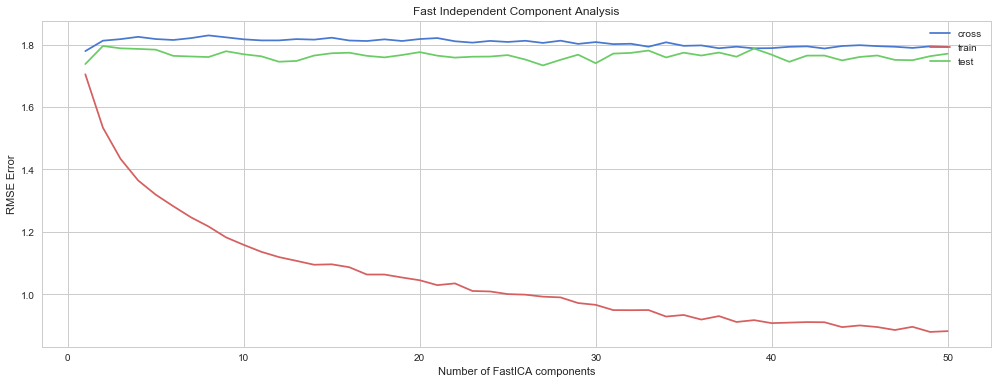

In [58]:
plt.figure(figsize=(17, 6))
plt.plot(score[0], score[1], color = "b")
plt.plot(score[0], score[2], color = "r")
plt.plot(score[0], score[3], color = "g")
plt.title('Fast Independent Component Analysis')
plt.ylabel('RMSE Error')
plt.xlabel('Number of FastICA components')
plt.legend(['cross','train','test'], loc='upper right')
plt.show()

Fast Independent Component Analysis does not produce useful components for the prediction so no component were selected.

### NMF Non-Negative Matrix Factorization

Non-Negative Matrix Factorization (NMF)

Find two non-negative matrices (W, H) whose product approximates the non- negative matrix X. This factorization can be used for example for dimensionality reduction, source separation or topic extraction.

In [59]:
nfm = NMF(n_components=100, init=None, solver="cd", beta_loss="frobenius", tol=0.0001, max_iter=200, random_state=None, alpha=0.0, l1_ratio=0.0, verbose=0, shuffle=False)
train_NFM = nfm.fit_transform(train)


In [60]:
reg = LGBMRegressor(objective='regression', metric='rmse')

score = [[],[],[],[]]

for i in range(1,51,1):
    
    X1, X2, y1, y2 = train_test_split(train_NFM[:,:i], y_train.values, test_size=0.20, random_state=0)
    
    scores = cross_val_score(reg, train_NFM[:,:i], y_train.values, cv=5, scoring=my_scorer)
    
    reg.fit(X1,y1)
    score[0].append(i)
    score[1].append(scores.mean())
    score[2].append(scoring_fun(y1,reg.predict(X1)))
    score[3].append(scoring_fun(y2,reg.predict(X2)))

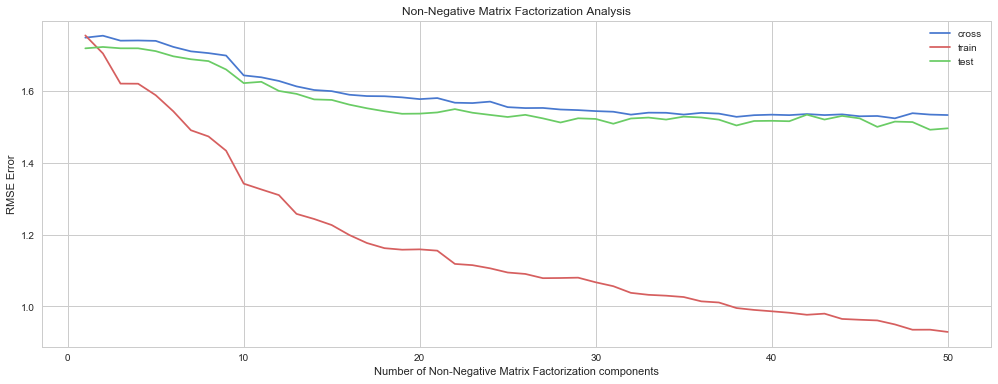

In [61]:
plt.figure(figsize=(17, 6))
plt.plot(score[0], score[1], color = "b")
plt.plot(score[0], score[2], color = "r")
plt.plot(score[0], score[3], color = "g")
plt.title('Non-Negative Matrix Factorization Analysis')
plt.ylabel('RMSE Error')
plt.xlabel('Number of Non-Negative Matrix Factorization components')
plt.legend(['cross','train','test'], loc='upper right')
plt.show()

Concatenating the different decomposition components, which will be added to the main data.

In [62]:
train_PCA = train_PCA[:,:20]
train_SRP = train_SRP[:,:75]
train_NFM = train_NFM[:,:40]

train_dec = np.hstack((train_SRP, train_PCA, train_NFM))

if include_test:
    test_PCA = pca.transform(test)
    test_SRP = srp.transform(test)
    test_NFM = nfm.transform(test)
    
    test_PCA = test_PCA[:,:20]
    test_SRP = test_SRP[:,:75]
    test_NFM = test_NFM[:,:40]
    
    test_dec = np.hstack((test_SRP, test_PCA, test_NFM))

print(train_dec.shape)

if include_test:
    print(test_dec.shape)

(4459, 135)


We will check for the high correlation between different components by plotting the correlation of the components on a heatmap. Using this checking process one can see that PCA components highly correlate with tSVD components so the latter have been excluded from the analysis.

In [63]:
data_corr = pd.DataFrame(train_dec).corr()

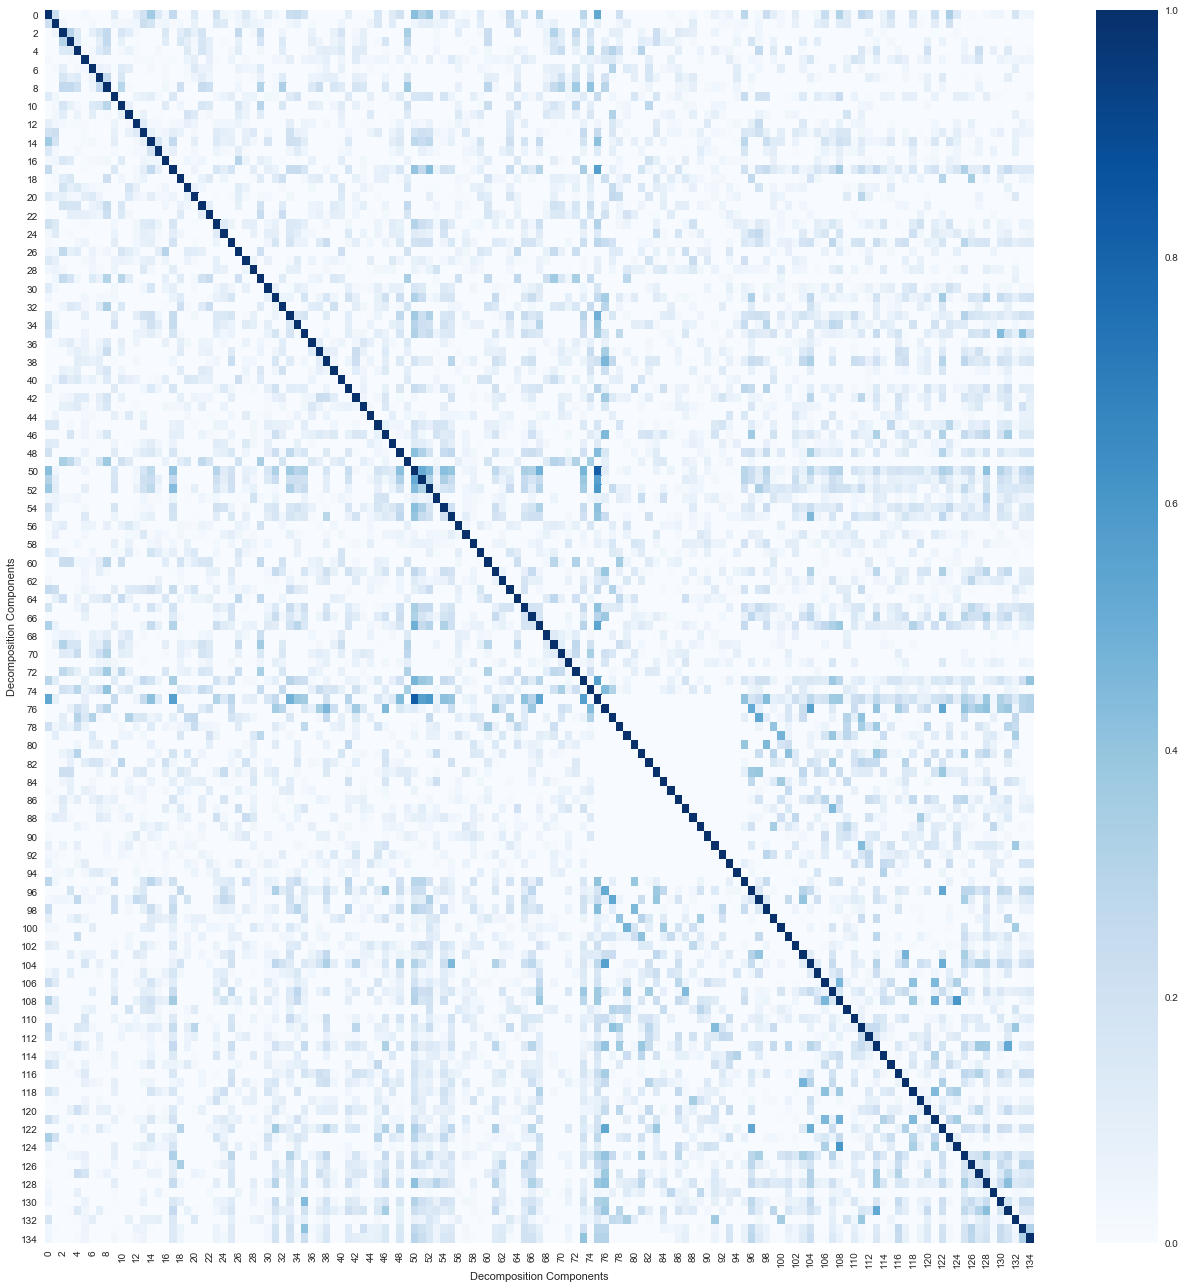

In [64]:
# Set up the matplotlib figure
f, axes = plt.subplots(figsize=(18, 18), sharex=True)

# Plot a simple histogram with binsize determined automatically
heatmap(data_corr, vmin=0, vmax=1, cmap="Blues")
plt.ylabel('Decomposition Components')
plt.xlabel('Decomposition Components')
plt.tight_layout()

We can also see the performance of the concatenated decomposition components by fitting the LGBMRegressor.

In [65]:
model = LGBMRegressor(objective='regression', metric='rmse') 

scores = cross_val_score(model, train_dec, y_train.values, cv=5, scoring=my_scorer)
print("Cross-Validation Error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

X1, X2, y1, y2 = train_test_split(train_dec, y_train.values, test_size=0.20, random_state=0)

model.fit(X1,y1)
print("Train Error: %0.2f" % (scoring_fun(y1,model.predict(X1))))
print("Test Error: %0.2f" % (scoring_fun(y2,model.predict(X2))))

Cross-Validation Error: 1.47 (+/- 0.10)
Train Error: 0.67
Test Error: 1.44


In [66]:
print('np.any(np.isnan(total_df)', np.any(np.isnan(train_dec)))
print('np.all(np.isfinite(total_df)', np.all(np.isfinite(train_dec)))

np.any(np.isnan(total_df) False
np.all(np.isfinite(total_df) True


### Feature selection

Feature selection can be accomplished by selecting only the features with highest correlation with the target variable. One such algorithm is f_regression from SciKit Learn library. After running the algorithm we can sort feature by their importance. Using this sorted list we can test different subgroups of the features using LightGBM algorithm. We are going to test 30 different subgroups of the algorithm starting with 10 top features. The analysis will then be visualized.

In [67]:
corr = f_regression(train, y_train)

In [68]:
f_selection = pd.DataFrame({'importance': corr[1], 'feature': train.columns}).sort_values(
              by=['importance'], ascending=[False])

In [69]:
reg = LGBMRegressor(objective='regression', metric='rmse')
model = LGBMRegressor(objective='regression', metric='rmse')
model.fit(train, y_train)
score = [[],[],[],[]]
num_features = 10

corr = f_regression(train, y_train)

for i in range(30):

    col = pd.DataFrame({'importance': corr[1], 'feature': train.columns}).sort_values(
    by=['importance'], ascending=[False])[:num_features]['feature'].values
    
    X1, X2, y1, y2 = train_test_split(train[col], y_train.values, test_size=0.20, random_state=0)
    
    scores = cross_val_score(reg, train[col], y_train.values, cv=5, scoring=my_scorer)
    reg.fit(X1[col],y1)
    score[0].append(num_features)
    score[1].append(scores.mean())
    score[2].append(scoring_fun(y1,reg.predict(X1[col])))
    score[3].append(scoring_fun(y2,reg.predict(X2[col])))
    
    num_features =int(num_features * 1.2)

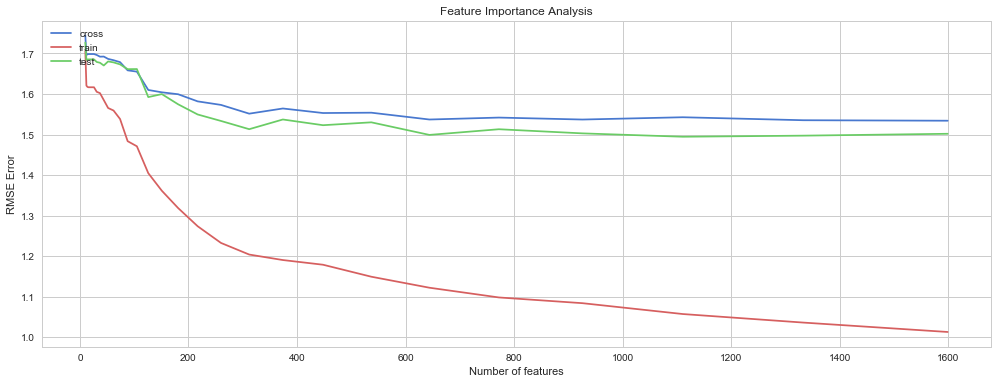

In [70]:
plt.figure(figsize=(17, 6))
plt.plot(score[0], score[1], color = "b")
plt.plot(score[0], score[2], color = "r")
plt.plot(score[0], score[3], color = "g")
plt.title('Feature Importance Analysis')
plt.ylabel('RMSE Error')
plt.xlabel('Number of features')
plt.legend(['cross','train','test'], loc='upper left')
plt.show()

It seems that after first 800 features there isn’t much improvement in cross-validation score. We can run another similar analysis using mutual information algorithm also from SciKit Learn.

In [71]:
corr = mutual_info_regression(train, y_train)

In [72]:
mi_selection = pd.DataFrame({'importance': corr, 'feature': train.columns}).sort_values(
              by=['importance'], ascending=[False])

In [73]:
reg = LGBMRegressor(objective='regression', metric='rmse')
model = LGBMRegressor(objective='regression', metric='rmse')
model.fit(train, y_train)
score = [[],[],[],[]]
num_features = 10

corr = f_regression(train, y_train)

for i in range(30):

    col = pd.DataFrame({'importance': corr[0], 'feature': train.columns}).sort_values(
    by=['importance'], ascending=[False])[:num_features]['feature'].values
    
    X1, X2, y1, y2 = train_test_split(train[col], y_train.values, test_size=0.20, random_state=0)
    
    scores = cross_val_score(reg, train[col], y_train.values, cv=5, scoring=my_scorer)
    reg.fit(X1[col],y1)
    score[0].append(num_features)
    score[1].append(scores.mean())
    score[2].append(scoring_fun(y1,reg.predict(X1[col])))
    score[3].append(scoring_fun(y2,reg.predict(X2[col])))
    
    num_features =int(num_features * 1.2)

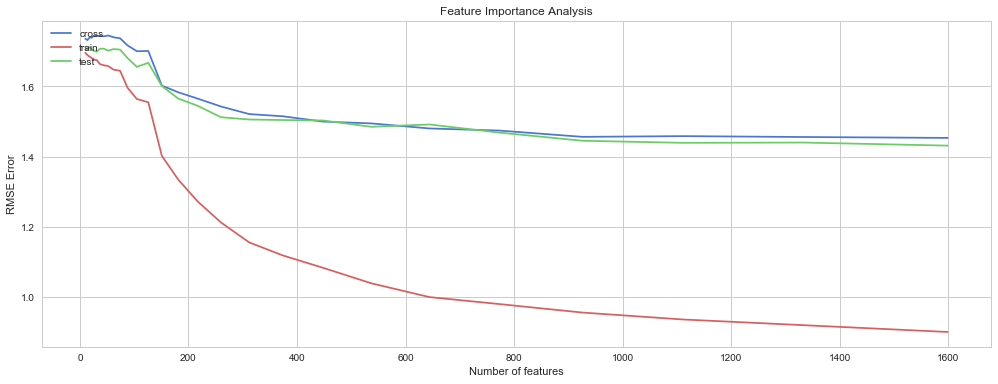

In [74]:
plt.figure(figsize=(17, 6))
plt.plot(score[0], score[1], color = "b")
plt.plot(score[0], score[2], color = "r")
plt.plot(score[0], score[3], color = "g")
plt.title('Feature Importance Analysis')
plt.ylabel('RMSE Error')
plt.xlabel('Number of features')
plt.legend(['cross','train','test'], loc='upper left')
plt.show()

After testing the concatenated data with mutual information vs univariate feature regression, mutual information component produces lower score and so were no used in further analysis.

### Data Expansion

Additional method of feature engineering is to expand the data. The data is usually expended row wise with various statistical functions like mean, standard deviation, number of non-zero entries, and many other statistical or custom defined functions. The entire list can be seen below.

In [75]:
tqdm.pandas()

def aggregate_row(row):
    non_zero_values = row.iloc[row.nonzero()].astype(float)
    if non_zero_values.empty:
        '''
        aggs = {
            'non_zero_mean': np.nan,
            'non_zero_std': np.nan,
            'non_zero_max': np.nan,
            'non_zero_min': np.nan,
            'non_zero_sum': np.nan,
            'non_zero_skewness': np.nan,
            'non_zero_kurtosis': np.nan,
            'non_zero_moment': np.nan,
            'non_zero_log_q1': np.nan,
            'non_zero_log_q3': np.nan
        }
        '''
        aggs = {
            'non_zero_mean': 0.0,
            'non_zero_std': 0.0,
            'non_zero_max': 0.0,
            'non_zero_min': 0.0,
            'non_zero_sum': 0.0,
            'non_zero_skewness': 0.0,
            'non_zero_kurtosis': 0.0,
            'non_zero_moment': 0.0,
            'non_zero_log_q1': 0.0,
            'non_zero_log_q3': 0.0
        }

        
    else:
        aggs = {
            'non_zero_mean': non_zero_values.mean(),
            'non_zero_std': non_zero_values.std(),
            'non_zero_max': non_zero_values.max(),
            'non_zero_min': non_zero_values.min(),
            'non_zero_sum': non_zero_values.sum(),
            'non_zero_skewness': skew(non_zero_values),
            'non_zero_kurtosis': kurtosis(non_zero_values),
            'non_zero_moment': moment(non_zero_values),
            'non_zero_log_q1': np.percentile(np.log1p(non_zero_values), q=25),
            'non_zero_log_q3': np.percentile(np.log1p(non_zero_values), q=75)
        }
    return pd.Series(aggs, index=list(aggs.keys()))


eng_features_train = train.iloc[:, 2:].progress_apply(aggregate_row, axis=1)
if include_test:
    eng_features_test = test.iloc[:, 2:].progress_apply(aggregate_row, axis=1)



4460it [00:06, 670.21it/s]                                                                                             


We should test our newly created data for high correlation between the components and remove items which high correlation.


In [76]:
data_corr = pd.DataFrame(eng_features_train).corr()

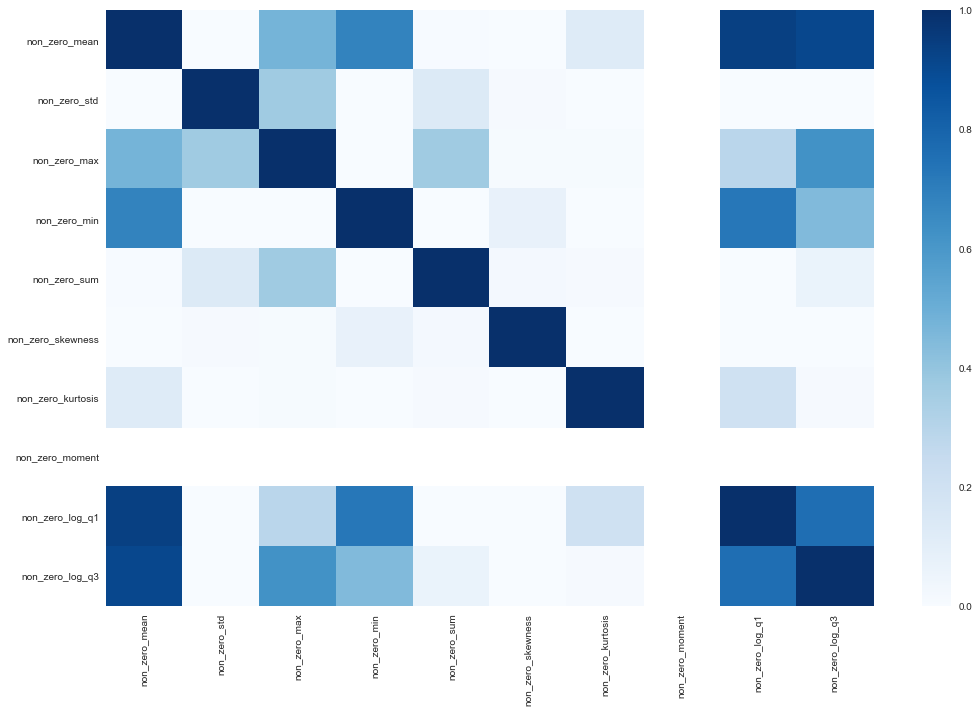

In [77]:
# Set up the matplotlib figure
f, axes = plt.subplots(figsize=(15, 10))

# Plot a simple histogram with binsize determined automatically
heatmap(data_corr, vmin=0, vmax=1, cmap="Blues")

plt.tight_layout()

The heatmap above shows that no two newly created features are two similar requiring removal. We can concatenate the created data with the original dataset after the removal of features using mutual information analysis.

In [78]:
col = pd.DataFrame({'importance': corr[1], 'feature': train.columns}).sort_values(
by=['importance'], ascending=[False])[:800]['feature'].values

In [79]:
train = train[col]
print(train.shape)

if include_test:
    test = test[col]
    print(test.shape)

In [80]:
# Concatenate the data

train = pd.concat([train, eng_features_train], axis=1)
if include_test:
    test = pd.concat([test, eng_features_test], axis=1)

print(train.shape)

if include_test:
    print(test.shape)

(4459, 810)


We can also test the performance of the newly expanded data using the LGBMRegressor.

In [81]:
model = LGBMRegressor(objective='regression', metric='rmse') 

scores = cross_val_score(model, train, y_train.values, cv=5, scoring=my_scorer)
print("Cross-Validation Error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

X1, X2, y1, y2 = train_test_split(train, y_train.values, test_size=0.20, random_state=0)

model.fit(X1,y1)
print("Train Error: %0.2f" % (scoring_fun(y1,model.predict(X1))))
print("Test Error: %0.2f" % (scoring_fun(y2,model.predict(X2))))

Cross-Validation Error: 1.39 (+/- 0.07)
Train Error: 0.86
Test Error: 1.38


We can see a significant improvement over the non-expanded data. Now we can expand the data with the decomposition components.

In [82]:
# Concatenate the data with the decomposiotion components

train_dec = pd.DataFrame(train_dec)

train = pd.concat([train, train_dec], axis=1)
if include_test:
    test = pd.concat([test, test_dec], axis=1)

print(train.shape)

if include_test:
    print(test.shape)

(4459, 945)


Testing the performance of the newly expanded data using the LGBMRegressor.

In [83]:
model = LGBMRegressor(objective='regression', metric='rmse') 

scores = cross_val_score(model, train, y_train.values, cv=5, scoring=my_scorer)
print("Cross-Validation Error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

X1, X2, y1, y2 = train_test_split(train, y_train.values, test_size=0.20, random_state=0)

model.fit(X1,y1)
print("Train Error: %0.2f" % (scoring_fun(y1,model.predict(X1))))
print("Test Error: %0.2f" % (scoring_fun(y2,model.predict(X2))))

Cross-Validation Error: 1.36 (+/- 0.09)
Train Error: 0.64
Test Error: 1.33


The addition of the decomposition components also resulted in the lower error than non-expanded data.

### Feature Importance Analysis

Considering the high dimensionality of the data we can use the gradient boosted tree model to select k-best features and try the model on only these feature. Possibly some of the features are not as relevant and are prohibit the algorithm to find an optimal solution.

We will do that in four steps:

1. Fit the algorithm
2. Select n-features
3. Fit a new algorithm with these features
4. Plot the variables score and number of features

In [84]:
reg = LGBMRegressor(objective='regression', metric='rmse')
model = LGBMRegressor(objective='regression', metric='rmse')
model.fit(train, y_train)
score = [[],[],[],[]]
num_features = 10

for i in range(30):

    col = pd.DataFrame({'importance': model.feature_importances_, 'feature': train.columns}).sort_values(
    by=['importance'], ascending=[False])[:num_features]['feature'].values
    
    X1, X2, y1, y2 = train_test_split(train[col], y_train.values, test_size=0.20, random_state=0)
    
    scores = cross_val_score(reg, train[col], y_train.values, cv=5, scoring=my_scorer)
    reg.fit(X1[col],y1)
    score[0].append(num_features)
    score[1].append(scores.mean())
    score[2].append(scoring_fun(y1,reg.predict(X1[col])))
    score[3].append(scoring_fun(y2,reg.predict(X2[col])))
    
    num_features =int(num_features * 1.15)

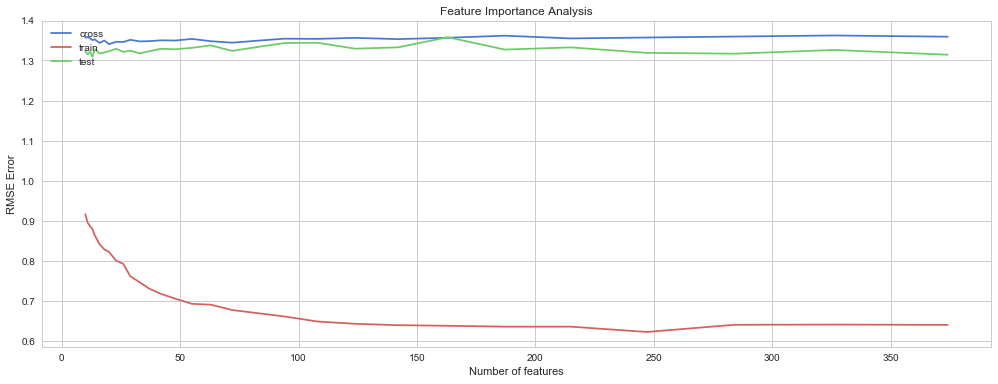

In [85]:
plt.figure(figsize=(17, 6))
plt.plot(score[0], score[1], color = "b")
plt.plot(score[0], score[2], color = "r")
plt.plot(score[0], score[3], color = "g")
plt.title('Feature Importance Analysis')
plt.ylabel('RMSE Error')
plt.xlabel('Number of features')
plt.legend(['cross','train','test'], loc='upper left')
plt.show()

Selecting features by importance has demonstrated that the model overfitts the data and that reducing the number of feature would not decrease the score. 

In [86]:
num_features = 150

col = pd.DataFrame({'importance': model.feature_importances_, 'feature': train.columns}).sort_values(
by=['importance'], ascending=[False])[:num_features]['feature'].values

train = train[col]

print(train.shape)

if include_test:
    test = test[col]
    print(test.shape)

(4459, 150)


### Model Tuning

Model tuning was performed using the random search through predefined hyperparameters. We have will search through 200 different hyperparameter combinations.

In [87]:
# Model tuning

best_score = 10e6
tuning_data = []

for i in range(100):
    
    num_leaves = np.random.choice([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130,
       135, 140, 145]) # default = 31, constraints: num_leaves > 1 
    
    min_data_in_leaf = np.random.choice([10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30])
    
    max_bin = np.random.choice([  50,  100,  150,  200,  250,  300,  350,  400,  450,  500,  550,
        600,  650,  700,  750,  800,  850,  900,  950, 1000, 1050, 1100,
       1150, 1200, 1250, 1300, 1350, 1400, 1450]) # default = 255, constraints: max_bin > 1
    
    learning_rate = np.random.choice([0.1, 0.075, 0.05, 0.025,  0.01, 0.0075, 0.005, 0.0025, 0.001, 0.00075, 0.0005, 0.00025, 0.0001])             
    
    n_estimators = np.random.choice([  50,  100,  150,  200,  250,  300,  350,  400,  450,  500,  550,
        600,  650,  700,  750,  800,  850,  900,  950, 1000, 1050, 1100,
       1150, 1200, 1250]) #  default = 100
    
    num_iterations = np.random.choice([ 15,  30,  45,  60,  75,  90, 105, 120, 135, 150, 165, 180, 195,
       210, 225, 240, 255, 270, 285, 300, 315, 330, 345, 360, 375, 390,
       405, 420, 435]) # default = 100
    
    boosting_type = np.random.choice(['gbdt', "rf", "dart", "goss"])
    
    max_depth = np.random.choice([2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
    
    bagging_fraction = np.random.choice([0.6 , 0.63, 0.66, 0.69, 0.72, 0.75, 0.78, 0.81, 0.84, 0.87, 0.9 ,
       0.93, 0.96, 0.99])
    
    bagging_freq = np.random.choice([2,3,4,5,6,7,8,9,10])
    
    feature_fraction = np.random.choice([0.7 , 0.73, 0.76, 0.79, 0.82, 0.85, 0.88, 0.91, 0.94, 0.97, 1.  ])
    
    lambda_l1 = np.random.choice([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]) #default = 0.0
    
    lambda_l2 = np.random.choice([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]) #default = 0.0
    
    
    # fine tuned selection
    boosting_type = np.random.choice(['gbdt'])
    
    opt_reg = LGBMRegressor(objective='regression',
                            boosting_type = boosting_type,
                            num_leaves = num_leaves,
                            min_data_in_leaf = min_data_in_leaf,
                            max_depth = max_depth,
                            learning_rate= learning_rate,
                            n_estimators= n_estimators,
                            num_iterations = num_iterations,
                            metric='rmse',
                            is_training_metric=True,
                            lambda_l1 = lambda_l1,
                            lambda_l2 = lambda_l2,
                            max_bin = max_bin,
                            bagging_fraction = bagging_fraction,
                            bagging_freq = bagging_freq,
                            feature_fraction = feature_fraction,
                            verbose=-1
                           )

    

    def scoring_fun(y, predy):
        return np.sqrt(mean_squared_error(y, predy))
    
    my_scorer = make_scorer(scoring_fun)

    #scores = cross_val_score(opt_reg, train[:int(train.shape[0]/10)], y_train.values[:int(train.shape[0]/10)], cv=5, scoring=my_scorer)
    scores = cross_val_score(opt_reg, train, y_train.values, cv=5, scoring=my_scorer)
    print("Error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    
    if scores.mean() < best_score:
        best_reg = opt_reg
        best_score = scores.mean()
    
    tuning_data.append([scores.mean(), opt_reg.get_params(), opt_reg])
    
    
    print("num_leaves:", num_leaves,
          "max_bin:", max_bin,
          "learning_rate:", learning_rate,
          "n_estimators:", n_estimators,
          "num_iterations:", num_iterations,
          "boosting_type:", boosting_type,
          "max_depth:", max_depth,
          "bagging_fraction:",bagging_fraction,
          "bagging_freq:",bagging_freq,
          "feature_fraction:",feature_fraction,
          "lambda_l1",lambda_l1,
          "lambda_l2",lambda_l2
         )
    print("")

Error: 1.45 (+/- 0.09)
num_leaves: 30 max_bin: 650 learning_rate: 0.0075 n_estimators: 450 num_iterations: 105 boosting_type: gbdt max_depth: 5 bagging_fraction: 0.87 bagging_freq: 7 feature_fraction: 0.85 lambda_l1 0.5 lambda_l2 0.5

Error: 1.36 (+/- 0.09)
num_leaves: 135 max_bin: 1200 learning_rate: 0.075 n_estimators: 1050 num_iterations: 345 boosting_type: gbdt max_depth: 18 bagging_fraction: 0.99 bagging_freq: 3 feature_fraction: 0.76 lambda_l1 0.55 lambda_l2 0.55

Error: 1.72 (+/- 0.09)
num_leaves: 135 max_bin: 500 learning_rate: 0.0005 n_estimators: 400 num_iterations: 105 boosting_type: gbdt max_depth: 19 bagging_fraction: 0.66 bagging_freq: 8 feature_fraction: 0.94 lambda_l1 0.55 lambda_l2 0.5

Error: 1.34 (+/- 0.09)
num_leaves: 75 max_bin: 600 learning_rate: 0.025 n_estimators: 600 num_iterations: 225 boosting_type: gbdt max_depth: 15 bagging_fraction: 0.99 bagging_freq: 5 feature_fraction: 0.76 lambda_l1 0.55 lambda_l2 0.55

Error: 1.72 (+/- 0.09)
num_leaves: 70 max_bin: 800

In [88]:
best_score

1.3324269872265568

In [89]:
best_reg

LGBMRegressor(bagging_fraction=0.96, bagging_freq=7, boosting_type='gbdt',
       class_weight=None, colsample_bytree=1.0, feature_fraction=0.73,
       is_training_metric=True, lambda_l1=0.4, lambda_l2=0.8,
       learning_rate=0.01, max_bin=1450, max_depth=11, metric='rmse',
       min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=24,
       min_split_gain=0.0, n_estimators=1200, n_jobs=-1,
       num_iterations=360, num_leaves=105, objective='regression',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
       verbose=-1)

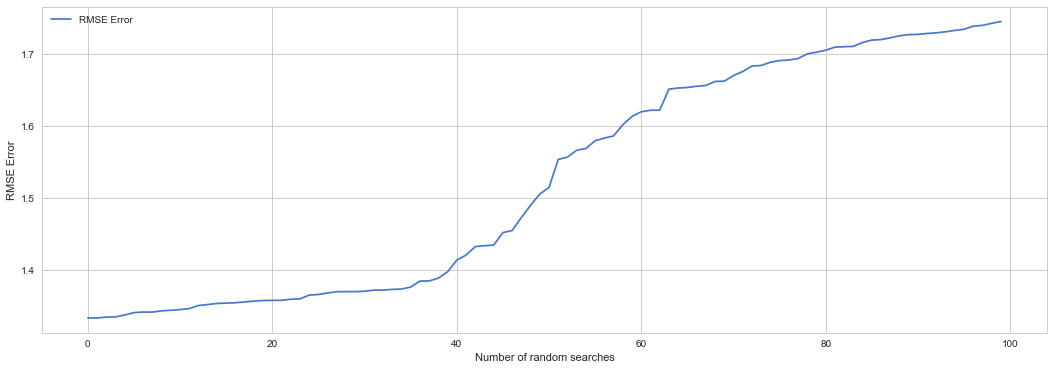

In [90]:
scores = []
for i in tuning_data:
    scores.append(i[0])

x = np.array(scores)
x.sort()
plt.figure(figsize=(18, 6))
plt.plot(x, color = "b", alpha = 1)
plt.title('')
plt.ylabel('RMSE Error')
plt.xlabel('Number of random searches')
plt.legend(['RMSE Error'], loc='upper left')
plt.show()


In [91]:

def scoring_fun(y, predy):
    return np.sqrt(mean_squared_error(y, predy))
    
my_scorer = make_scorer(scoring_fun)

scores = cross_val_score(best_reg, train, y_train.values, cv=5, scoring=my_scorer)
print("Cross-Validation Error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

X1, X2, y1, y2 = train_test_split(train, y_train.values, test_size=0.20, random_state=100)

best_reg.fit(X1,y1)
print("Train Error: %0.2f" % (scoring_fun(y1,best_reg.predict(X1))))
print("Test Error: %0.2f" % (scoring_fun(y2,best_reg.predict(X2))))


Cross-Validation Error: 1.33 (+/- 0.09)
Train Error: 0.74
Test Error: 1.30


This algorithm was used to predict the final test data. The final error on the test data was 1.41.